### Maze environment
Check out `maze.jl` to see the custom types and functions that define the belief_maze environment. 

In [13]:
include("includes/maze.jl")
Random.seed!(2)
environment, start = generate_nondet_environment(3);


In [14]:
include("includes/value_iteration.jl");
optimal_policy, optimal_values = value_iteration(environment.maze, environment.controller, 0.9, 0.01);
print_maze(environment, start, optimal_policy)

 #↓   .↓   #←  

 .→   G→   #←  

 X↑   .↑   .←  



## Learning belief models

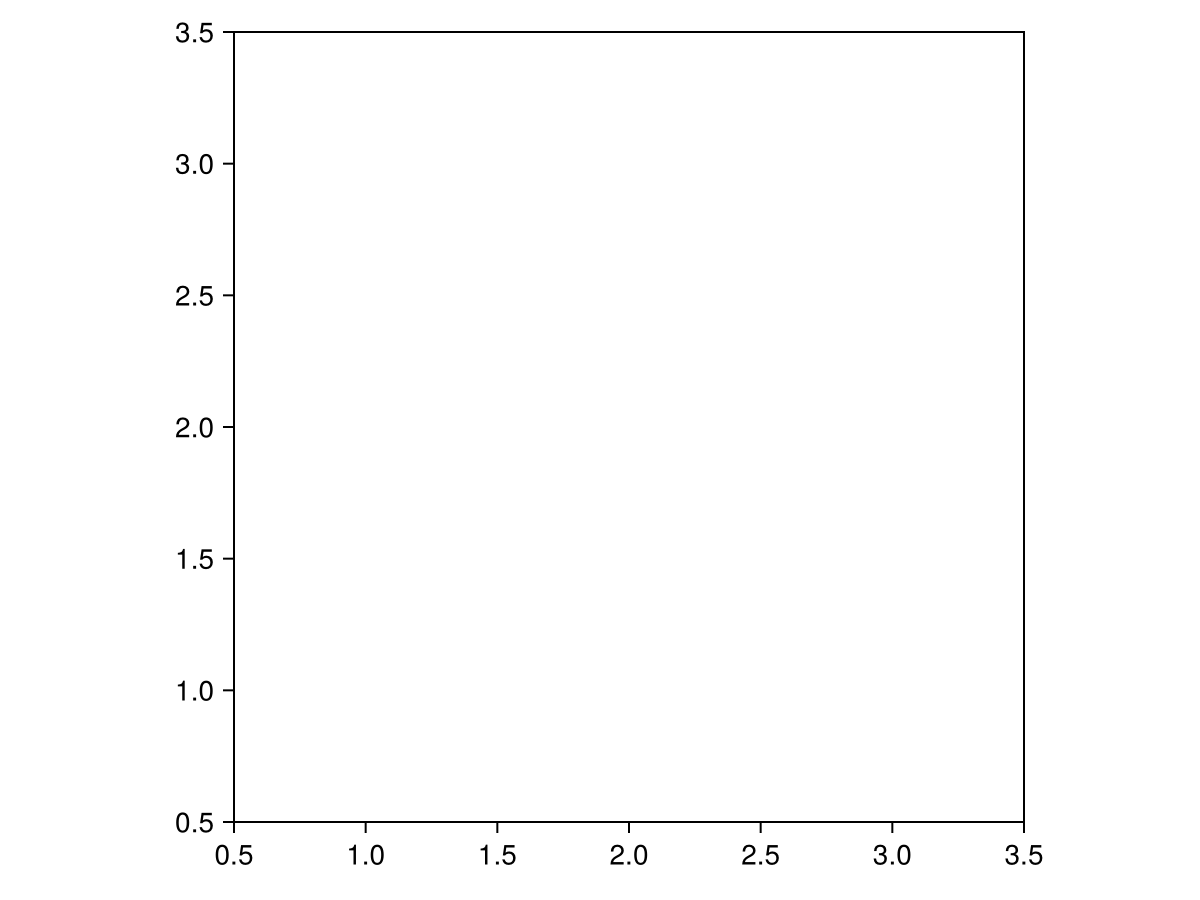

In [24]:
function get_belief_maze(traces)
    belief_maze = BeliefMaze()
    for pos in keys(traces[1][:maze])
        belief_maze[pos] = mean(trace[:maze][pos] == obstacle ? 0 : 1 for trace in traces)
    end
    return belief_maze
end;

plot_belief_maze(get_belief_maze(traces))


In [25]:
include("includes/gen_simulations.jl");

### Maze parameters

In [26]:
@dist function get_field(prob)
    index = binom(1, prob) 
    [obstacle, empty][index + 1]
end;

@gen function select_maze(n, start::Pos, goal_pos::Pos)::Maze
    maze = Maze()
    for x in 1:n
        for y in 1:n
            pos = Pos(x,y)
            if pos == goal_pos
                maze[pos] = {pos} ~ labeled_categorical([goal], [1])
            else
                if pos == start
                    maze[pos] = {pos} ~ labeled_categorical([empty], [1])
                else
                    maze[pos] = {pos} ~ get_field(0.8) 
                end
            end
        end
    end
    return maze
end;

In [27]:
maze = select_maze(3,Pos(1,1), Pos(3,3))
print_maze(maze, start)

 . . G
 . . .
 X . #


### Learning the maze

In [28]:
@gen function sample_goal(n::Int)
    positions = [Pos(x,y) for x in 1:n for y in 1:n]    
    goal_pos = {:goal_index} ~ uniform_discrete(1, length(positions))
    return positions[goal_pos]
end;

In [29]:
@gen function maze_model_known_controller(past_policies::Vector{Policy}, start::Pos, episode_length::Int)
    T = length(past_policies)
    n = Int(sqrt(length(past_policies[1])))
    g = {:goal} ~ sample_goal(n)
    maze = {:maze} ~ select_maze(n, start, g)

    # HARDCODED FOR NOW
    controller = environment.controller
    
    episodes = []
    for t in 1:T
        policy = past_policies[t]
        episode = {:episode => t} ~ simulate_episode(maze, controller, start, episode_length, policy)
        push!(episodes, episode)
    end
    
    return maze, g
end;

#### Propose from prior

In [30]:
function block_update_maze(trace, n)
    
    (trace,_) = mh(trace, select(:goal, :maze))
    
    return trace
end;

In [31]:
function update_choicemap(episodes::ChoiceMap, i::Int, episode::Episode, policy::Policy)
    for (j, pos) in enumerate(episode.visited)
        if j < length(episode.visited)
            episodes[:episode => i => j => pos => policy[pos] => :new_pos] = episode.visited[j+1]
            episodes[:episode => i => j => :reward] = episode.rewards[j]
        end
    end
    return episodes
end;

In [32]:
function iterative_thompson(environment::Environment, start::Pos, episode_length::Int, nr_episodes::Int, nr_burn::Int)
    Random.seed!(1)
    n = Int(sqrt(length(environment.maze)))
    policies = [random_policy(n)] 
    episodes = choicemap()
    ep = simulate_episode(environment.maze, environment.controller, start, episode_length, policies[1])
    episodes = update_choicemap(episodes, 1, ep, policies[1])

    trace, sc = generate(maze_model_known_controller, (policies, start, episode_length), episodes);
    traces = [trace]
    all_traces = []
    burned_traces = []
    new_burned_traces = []
    
    for t in 2:nr_episodes
        new_burned_traces = []
        for _ in 1:nr_burn
            trace = block_update_maze(trace, n)
            push!(burned_traces, trace)
            push!(new_burned_traces, trace)
            push!(all_traces, trace)
        end
        burned_traces = new_burned_traces 
        
        belief_maze = get_belief_maze(burned_traces)
        fig = plot_belief_maze(belief_maze)
        display(fig)

        push!(traces, trace)
        
        optimal_policy, _ = value_iteration(trace[:maze], environment.controller, 0.9, 0.01);

        push!(policies, optimal_policy)
        ep = simulate_episode(environment.maze, environment.controller, start, episode_length, optimal_policy)
        episodes = update_choicemap(episodes, t, ep, optimal_policy)

        (trace, _, _, _) = update(trace, (policies, start, episode_length), (), episodes)
    end

    # fig = plot_grid_field_evolution([get_belief_maze([trace]) for trace in all_traces])

    return policies, traces
end;

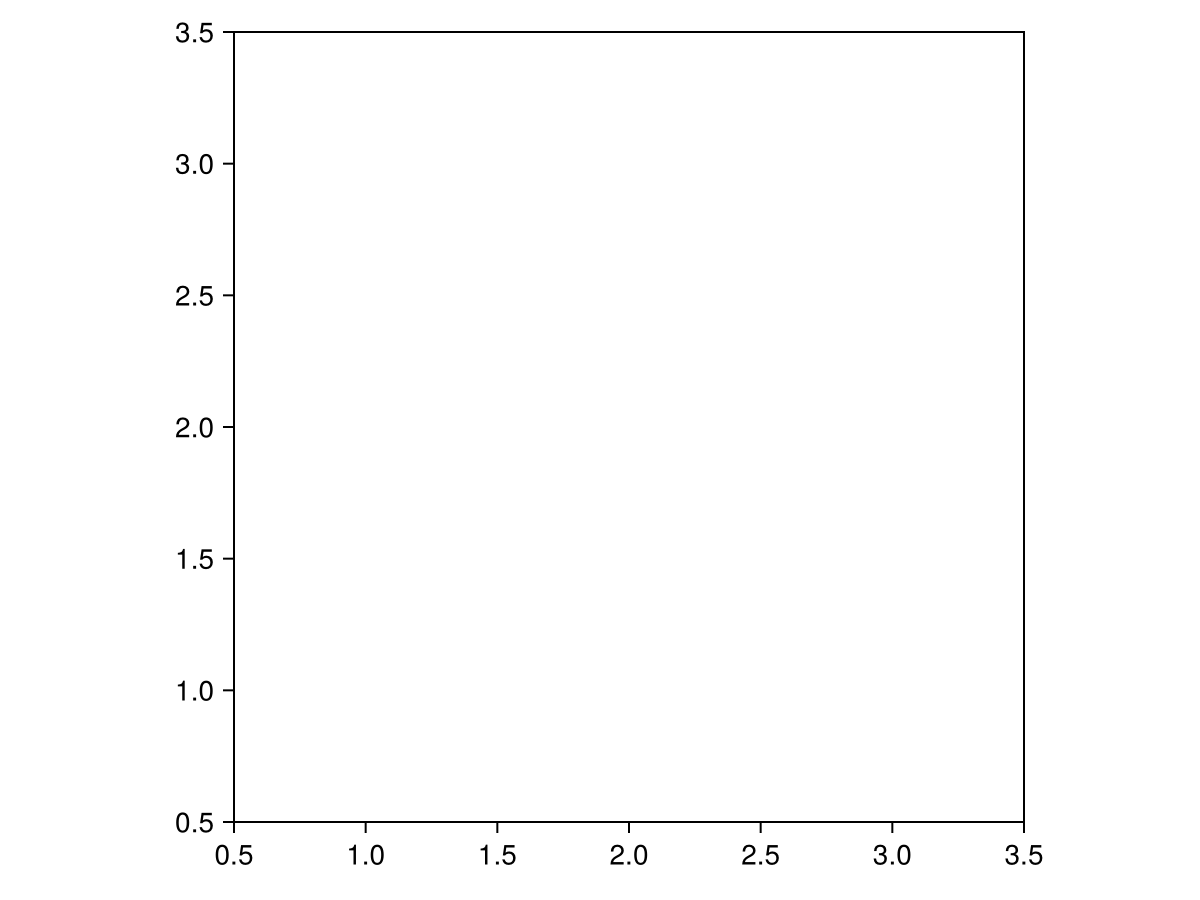

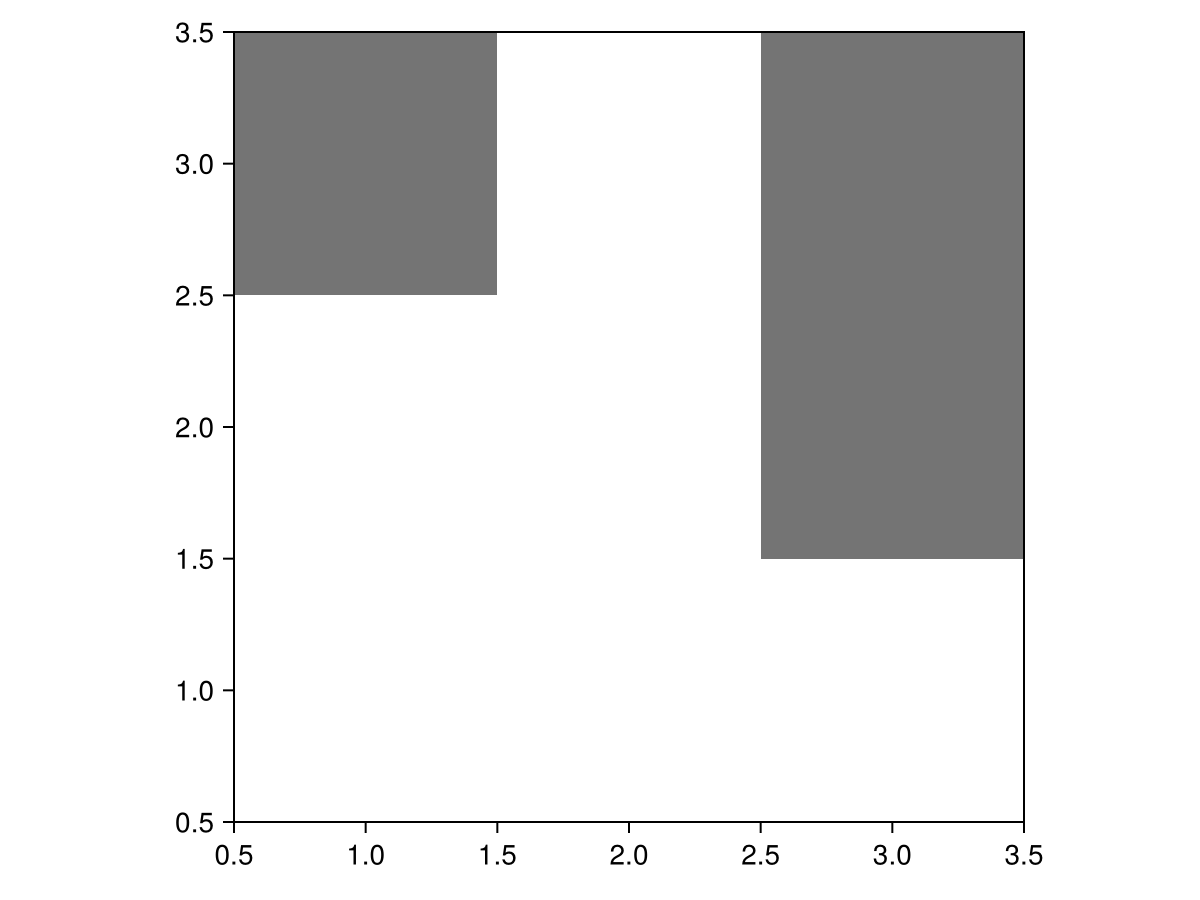

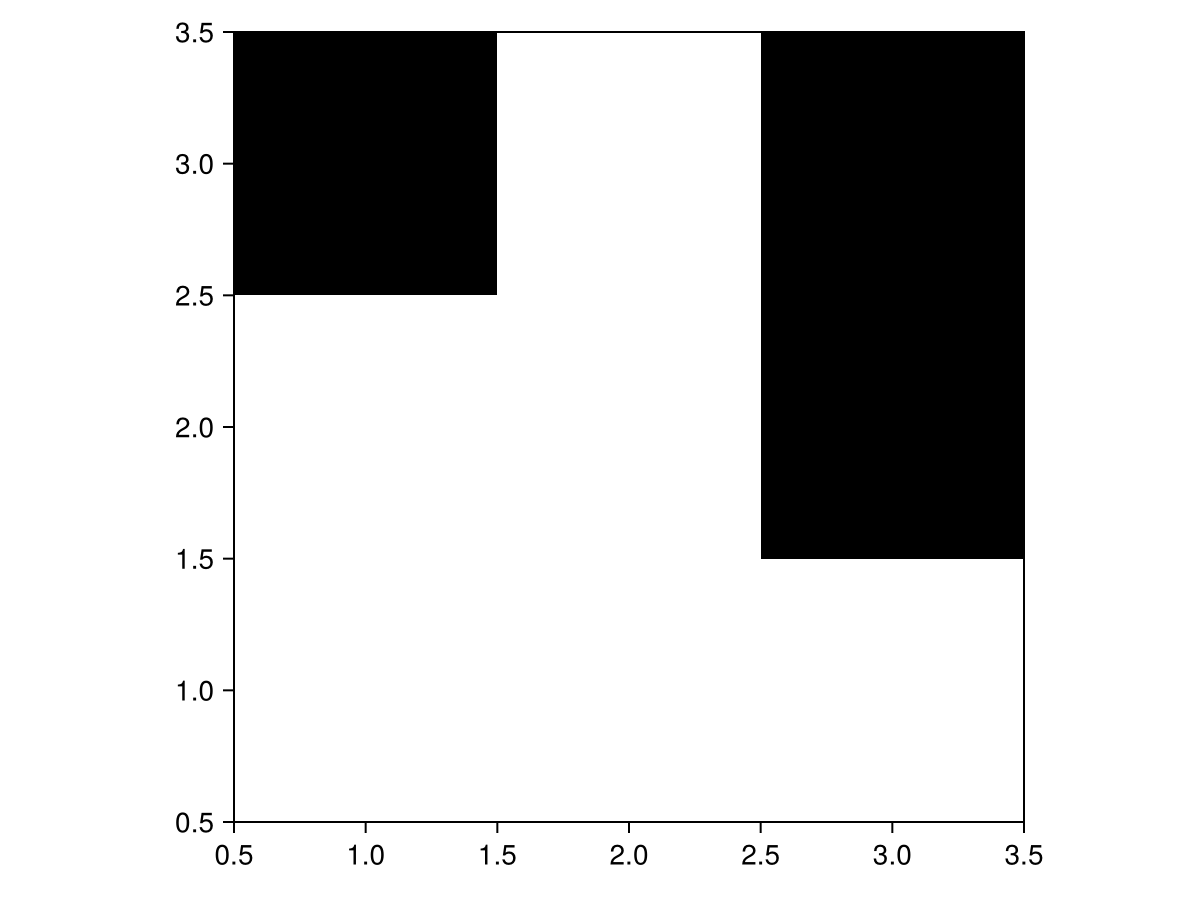

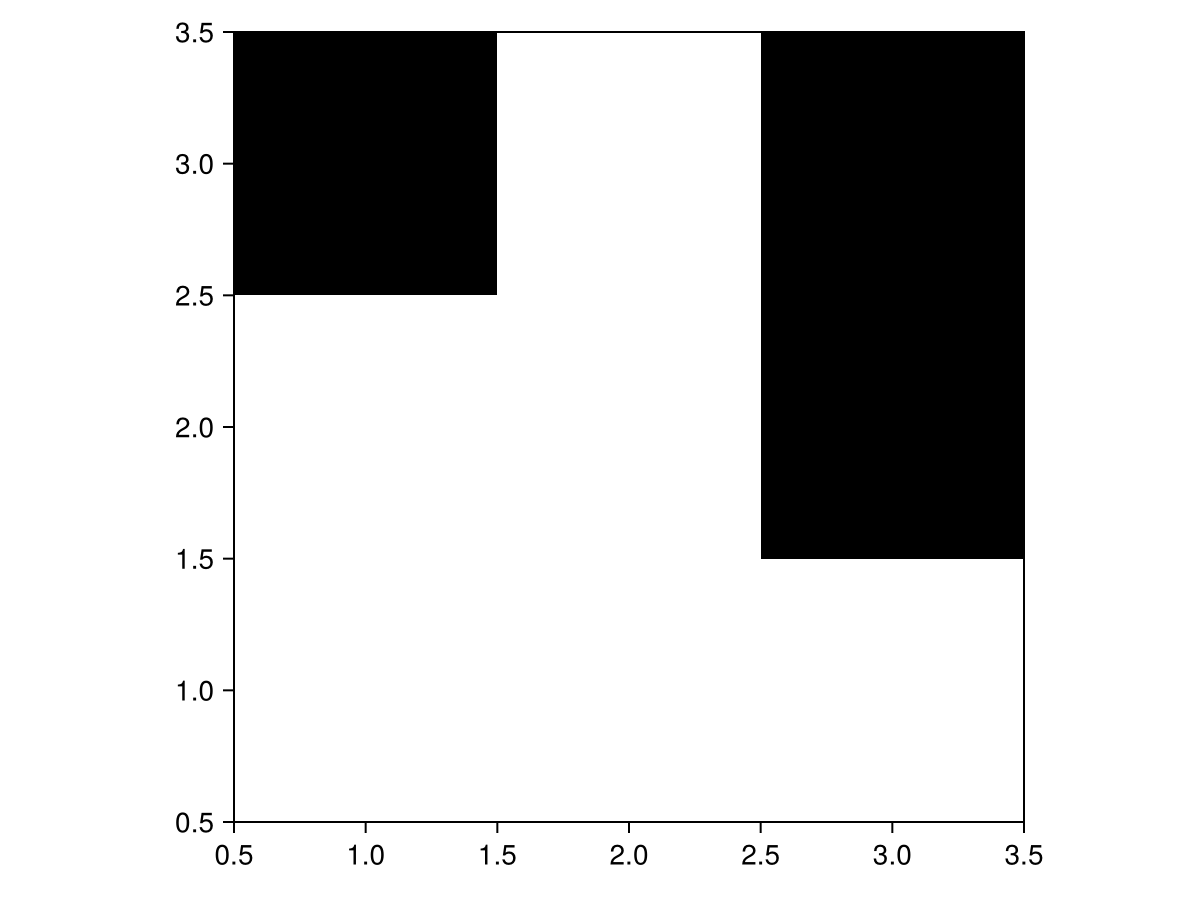

In [35]:
policies, traces = iterative_thompson(environment, start, 100, 5, 100);

In [12]:
length(traces)

10

In [13]:
print_maze(environment, start, policies[1])
print_maze(traces[1][:maze], start)

 #←   .↑   #←  

 .↓   G→   #→  

 X↑   .←   .→  

 . . .
 . . G
 X . .


In [14]:
print_maze(environment, start, policies[end])
print_maze(traces[end][:maze], start)

 #↓   .↓   #←  

 .→   G→   #←  

 X↑   .↑   .←  

 # . #
 . G #
 X . .


In [16]:
Random.seed!(1)
environment, start = generate_nondet_environment(4);

policies, traces = iterative_thompson(environment, start, 100, 10, 500);


for (i, pol) in enumerate(policies)
    print_maze(environment, start, pol)
    print_maze(traces[i][:maze], start)
    println()
end


 .↑   X→   .↓   #↑  

 .↑   .→   #↑   .↑  

 .↓   .←   #←   .←  

 G←   #→   #↑   #↓  

 # X # .
 . . . .
 . . . .
 . . G .

 .→   X↓   .←   #←  

 .↓   .↓   #←   .↓  

 .↓   .←   #←   .←  

 G←   #←   #↑   #←  

 . X . .
 # . # #
 . . . .
 G # . .

 .→   X↓   .←   #←  

 .↓   .↓   #←   .←  

 .↓   .←   #←   .←  

 G←   #←   #↑   #←  

 . X . #
 # . # .
 . . . #
 G # . .

 .→   X↓   .←   #←  

 .↓   .↓   #←   .←  

 .↓   .←   #←   .←  

 G←   #←   #↑   #←  

 . X . #
 # . # .
 . . . #
 G # . .

 .↓   X←   .←   #←  

 .↓   .←   #←   .←  

 .↓   .←   #←   .←  

 G←   #←   #←   #←  

 . X . #
 . . # .
 . . # .
 G # . #

 .↓   X←   .←   #←  

 .↓   .←   #←   .←  

 .↓   .←   #←   .←  

 G←   #←   #←   #←  

 . X . #
 . . # .
 . . # .
 G # . #

 .↓   X←   .←   #←  

 .↓   .←   #←   .←  

 .↓   .←   #←   .←  

 G←   #←   #←   #←  

 . X . #
 . . # .
 . . # .
 G # . #

 .↓   X←   .←   #←  

 .↓   .←   #←   .←  

 .↓   .←   #←   .←  

 G←   #←   #←   #←  

 . X . #
 . . # .
 . . # .
 G # . #



In [17]:
# Random.seed!(1)
# environment, start = generate_nondet_environment(10);

# policies, traces = iterative_thompson(environment, start, 100, 30, 500);


In [18]:

# print_maze(environment, start, policies[1])
# print_maze(traces[1][:maze], start)

# print_maze(environment, start, policies[end])
# print_maze(traces[end][:maze], start)

#### Propose from belief maze

In [36]:
@gen function propose_maze(trace, start, history)
    episodes = [trace[:episode => i] for i in 1:length(collect(get_submaps_shallow(get_submap(get_choices(trace), :episode))))]
    n = sqrt(length(trace[:maze]))
    positions = [Pos(x,y) for x in 1:n for y in 1:n]
    old_goal = positions[trace[:goal => :goal_index]]
    goal_pos = nothing
    visited_positions = Dict{Pos,Bool}()

    # check if the goal was already found and save visited positions
    for (i, episode) in enumerate(episodes)
        for (j, reward) in enumerate(episode.rewards)
            pos = episode.visited[j+1]
            if reward == 100 
                goal_pos = pos
            end
            visited_positions[pos] = true
        end
    end
    
    # # sample the goal based on findings
    if goal_pos != nothing
        goal_index = findfirst(x -> x == goal_pos, positions)
        probabilities = [pos == goal_pos ? 100 : 1 for pos in positions]
        probabilities = probabilities / sum(probabilities)
        goal_ix = {:goal => :goal_index} ~ labeled_categorical([i for i in 1:length(positions)], probabilities)
        goal_pos = positions[goal_ix]
    else
        probabilities = [haskey(visited_positions, pos) ? 1 : 100 for pos in positions]
        probabilities = probabilities / sum(probabilities)
        goal_ix = {:goal => :goal_index} ~ labeled_categorical([i for i in 1:length(positions)], probabilities)
        goal_pos = positions[goal_ix]
    end

    # sample the maze based on goal and visited positions

    # rest stays the same
    for pos in keys(trace[:maze])
        if pos == goal_pos
            {:maze => pos} ~ labeled_categorical([obstacle, empty, goal], [0.001, 0.001, 0.998])
        elseif pos == start
            {:maze => pos} ~ labeled_categorical([obstacle, empty, goal], [0.001, 0.998, 0.001])
        elseif haskey(visited_positions, pos)
            {:maze => pos} ~ labeled_categorical([obstacle, empty, goal], [0.001, 0.998, 0.001])
        else
            # # sampling from posterior
            # a = 1 + (length(history) > 0 ? sum(trace[:maze][pos] == obstacle for trace in history) : 0)
            # b = 1 + (length(history) > 0 ? sum(trace[:maze][pos] != obstacle for trace in history) : 0)
            # # probabilities = [a, b, 0.01]
            # exp = a / (a + b)
            # # probabilities = probabilities / sum(probabilities)
            # # {:maze => pos} ~ labeled_categorical([obstacle, empty, goal], probabilities)
            # {:maze => pos} ~ get_field(exp)

            
            # sampling from prior
            {:maze => pos} ~ get_field(0.8)
        end
    end
end;
    

In [37]:
function propose_update(trace, start::Pos, history)
    (trace,_) = mh(trace, propose_maze, (start, history))
    
    # for pos in keys(trace[:maze])
    #     (trace, _) = mh(trace, select(:maze => pos))
    # end

    return trace

end;

In [38]:
function iterative_thompson_propose(environment::Environment, start::Pos, episode_length::Int, nr_episodes::Int, nr_burn::Int)
    Random.seed!(1)
    n = Int(sqrt(length(environment.maze)))
    policies = [random_policy(n)] 
    episodes = choicemap()
    ep = simulate_episode(environment.maze, environment.controller, start, episode_length, policies[1])
    episodes = update_choicemap(episodes, 1, ep, policies[1])

    trace, sc = generate(maze_model_known_controller, (policies, start, episode_length), episodes);
    traces = [trace]
    all_traces = []
    burned_traces = []
    new_burned_traces = []
    
    for t in 2:nr_episodes
        # burn traces using drift update
        new_burned_traces = []
        for _ in 1:nr_burn
            trace = propose_update(trace, start, all_traces)
            push!(burned_traces, trace)
            push!(new_burned_traces, trace)
            push!(all_traces, trace)
        end
        burned_traces = new_burned_traces 
        
        belief_maze = get_belief_maze(all_traces)
        fig = plot_belief_maze(belief_maze)
        display(fig)
        
        push!(traces, trace)
        
        optimal_policy, _ = value_iteration(trace[:maze], environment.controller, 0.9, 0.01);
        print_maze(trace[:maze], start)

        push!(policies, optimal_policy)
        ep = simulate_episode(environment.maze, environment.controller, start, episode_length, optimal_policy)
        episodes = update_choicemap(episodes, t, ep, optimal_policy)

        (trace, _, _, _) = update(trace, (policies, start, episode_length), (), episodes)
    end

    # fig = plot_grid_field_evolution([get_belief_maze([trace]) for trace in all_traces])

    return policies, traces
end;

In [39]:
Random.seed!(1)
environment, start = generate_nondet_environment(4);


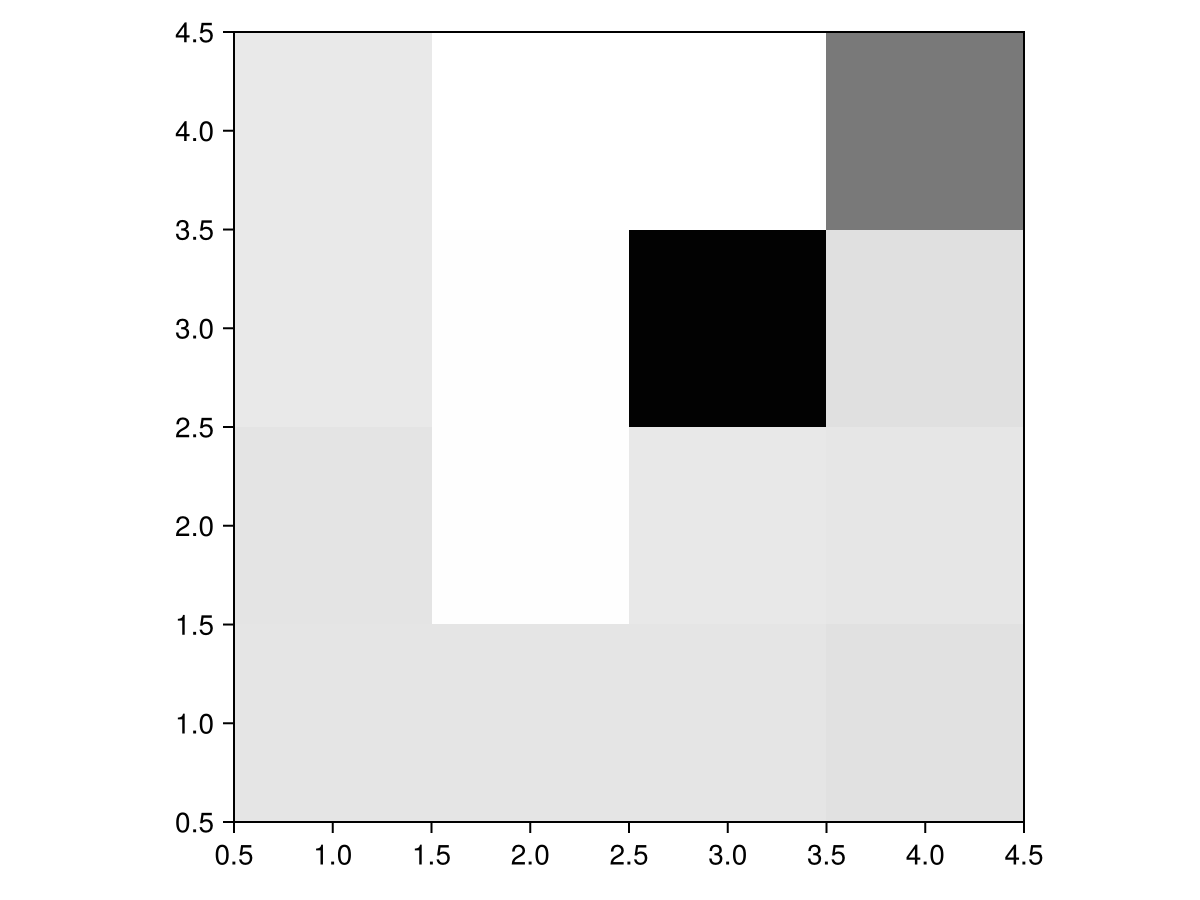

 . X . .
 . . # .
 G . . .
 . . . .


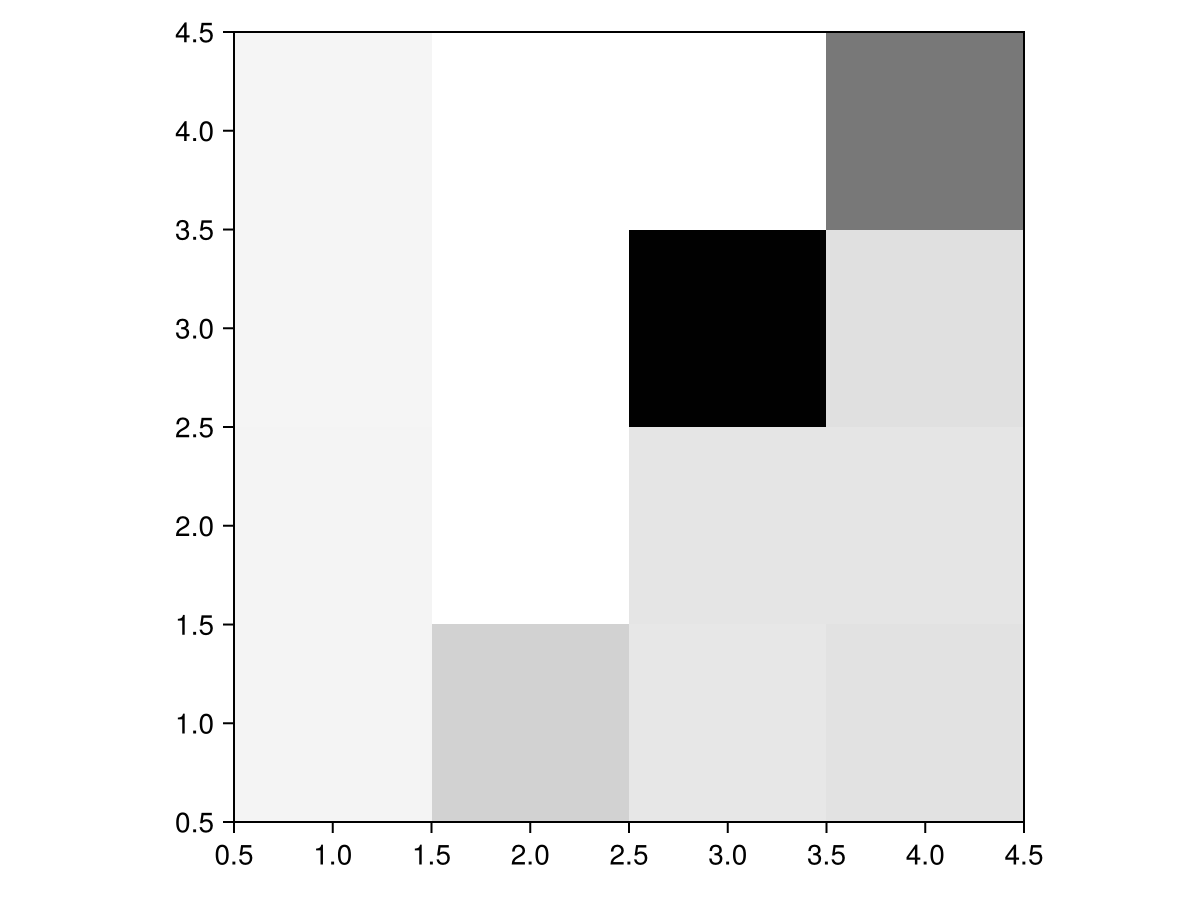

 . X . .
 . . # #
 . . . #
 G . . #


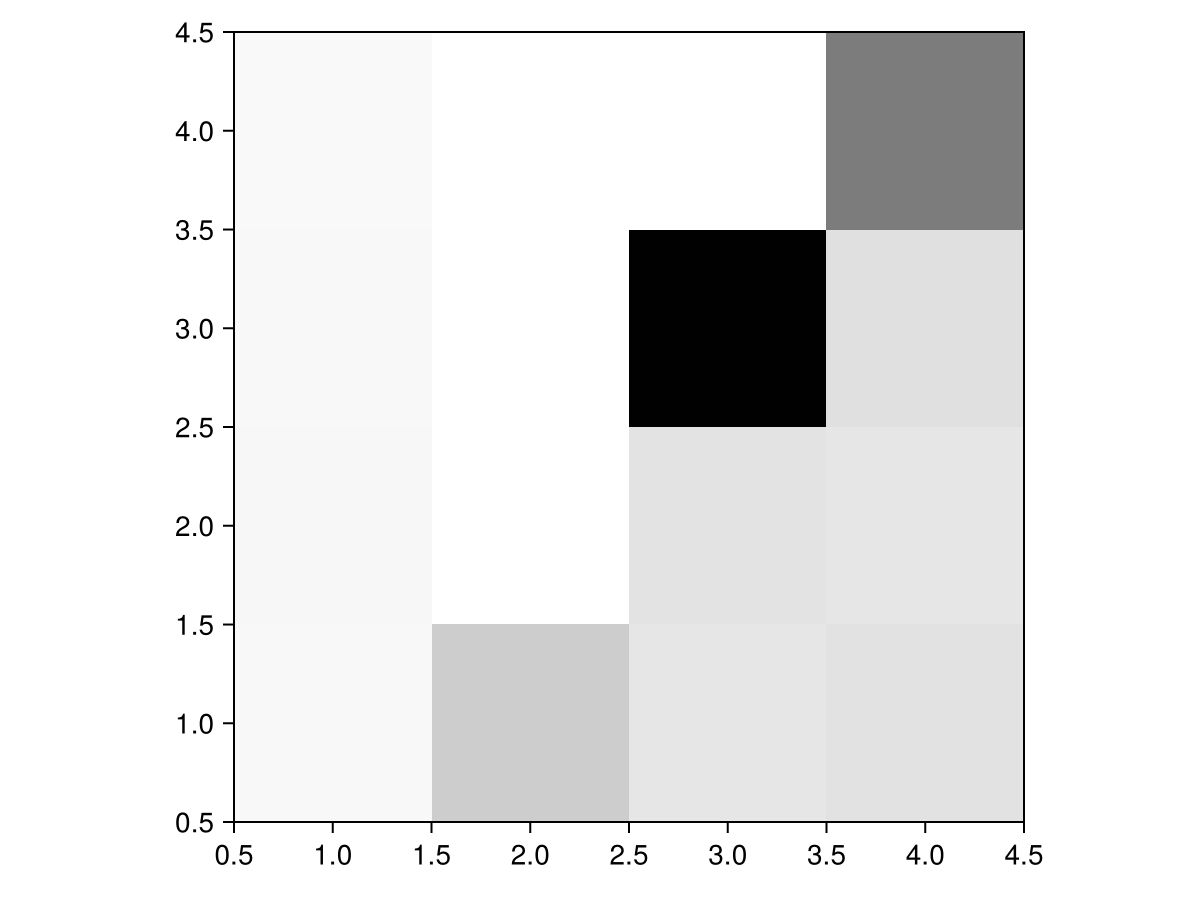

 . X . .
 . . # .
 . . . .
 G # # .


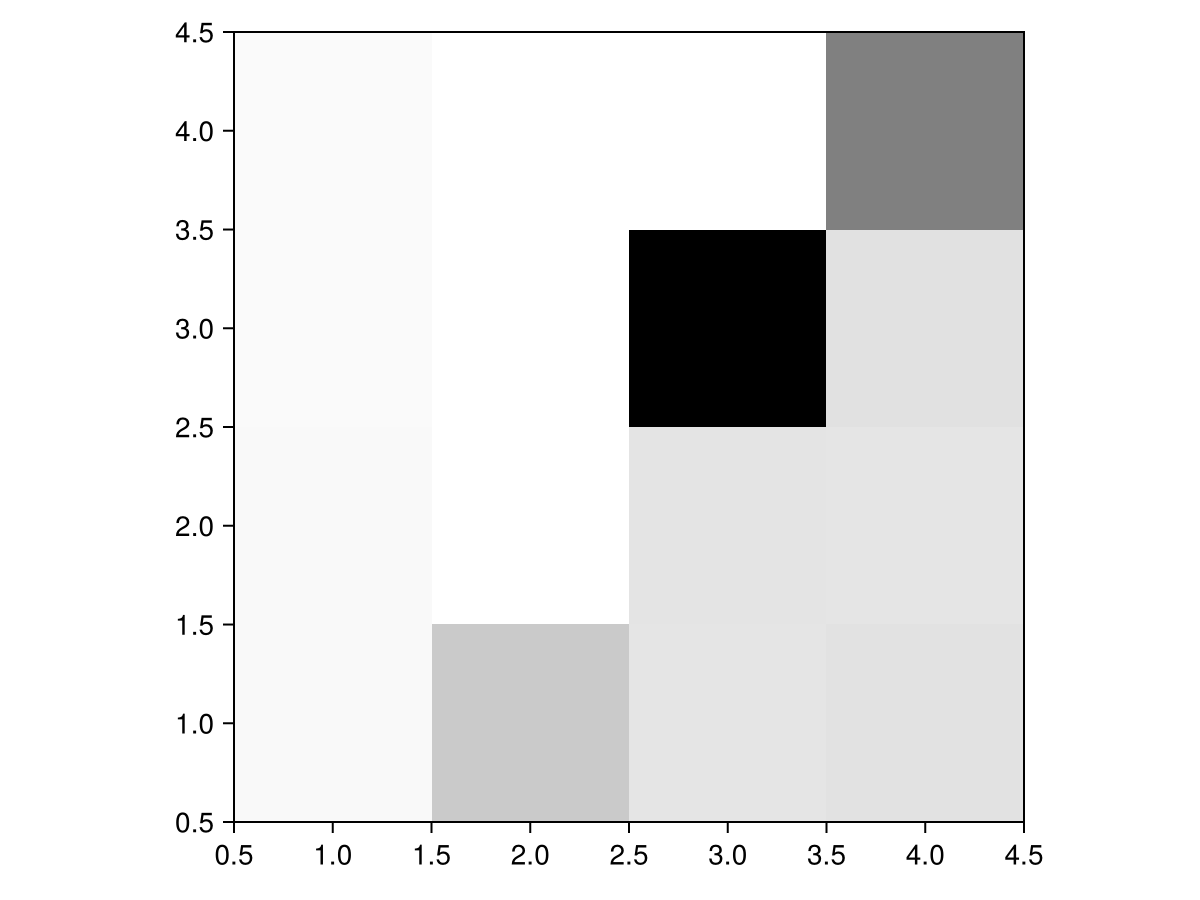

 . X . .
 . . # .
 . . . .
 G . . #


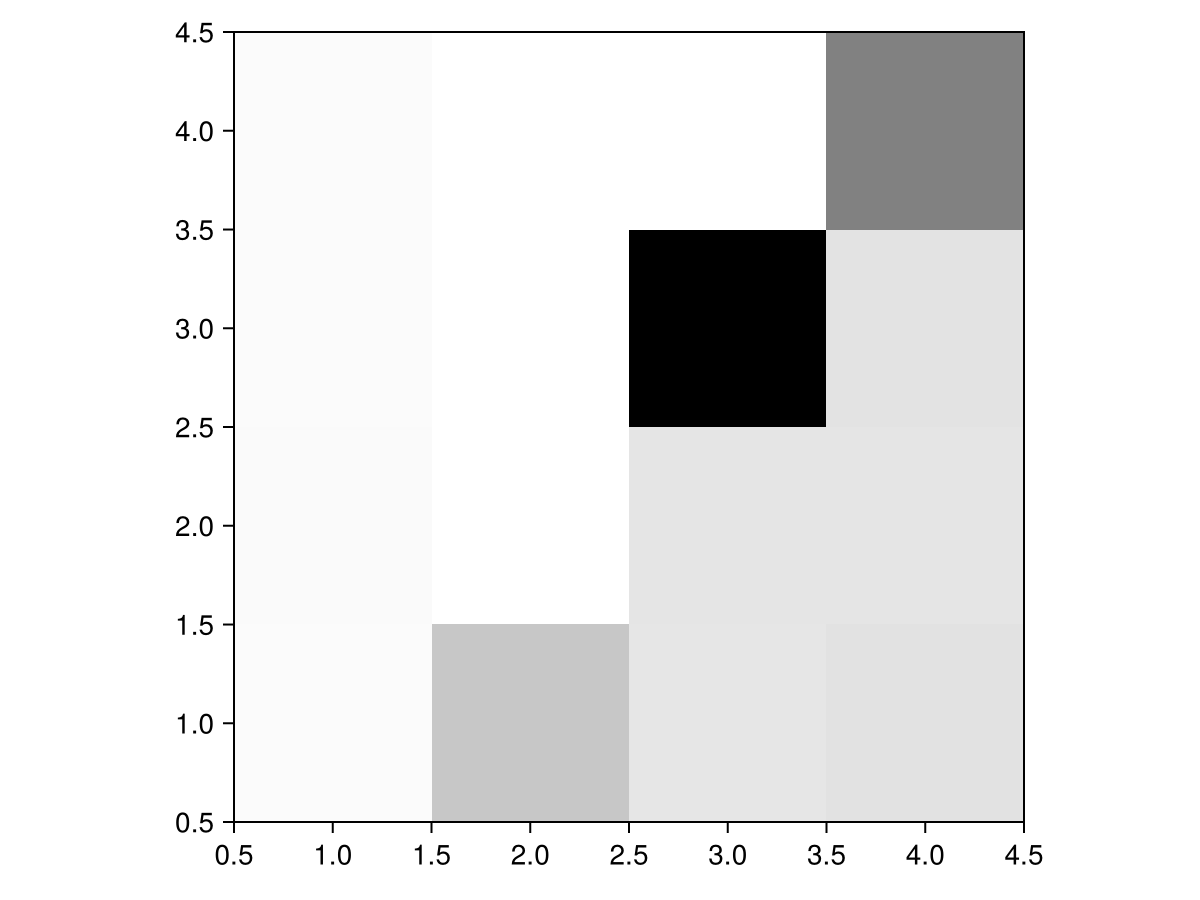

 . X . #
 . . # .
 . . . .
 G . . .


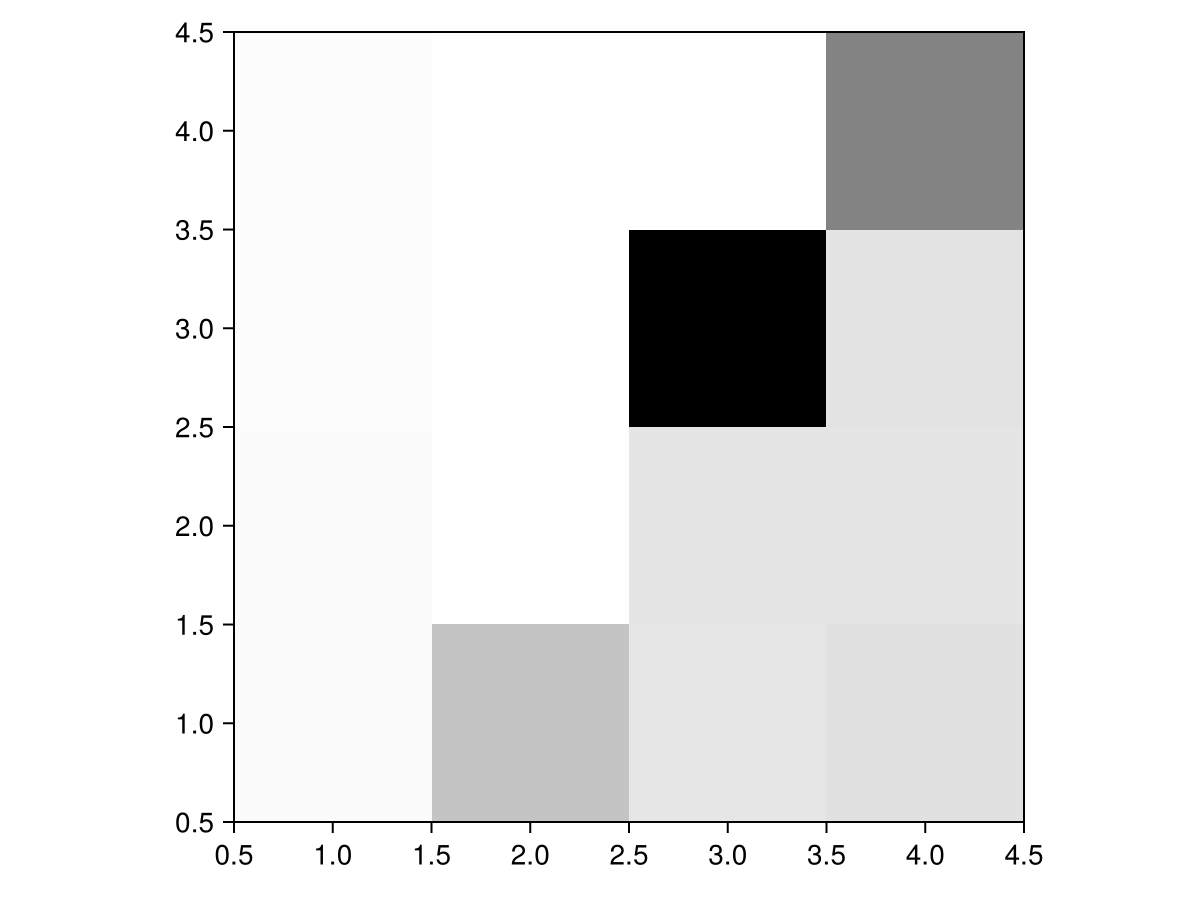

 . X . .
 . . # #
 . . . .
 G . # .


In [658]:
policies, traces = iterative_thompson_propose(environment, start, 30, 7, 310);


In [659]:
print_maze(environment.maze, start)

 . X . #
 . . # .
 . . # .
 G # # #


 . . . . . . .
 . G . . . # .
 . . . # . . .
 . . . # . X .
 . . . . . . .
 . . . . # . #
 . # # . . . .


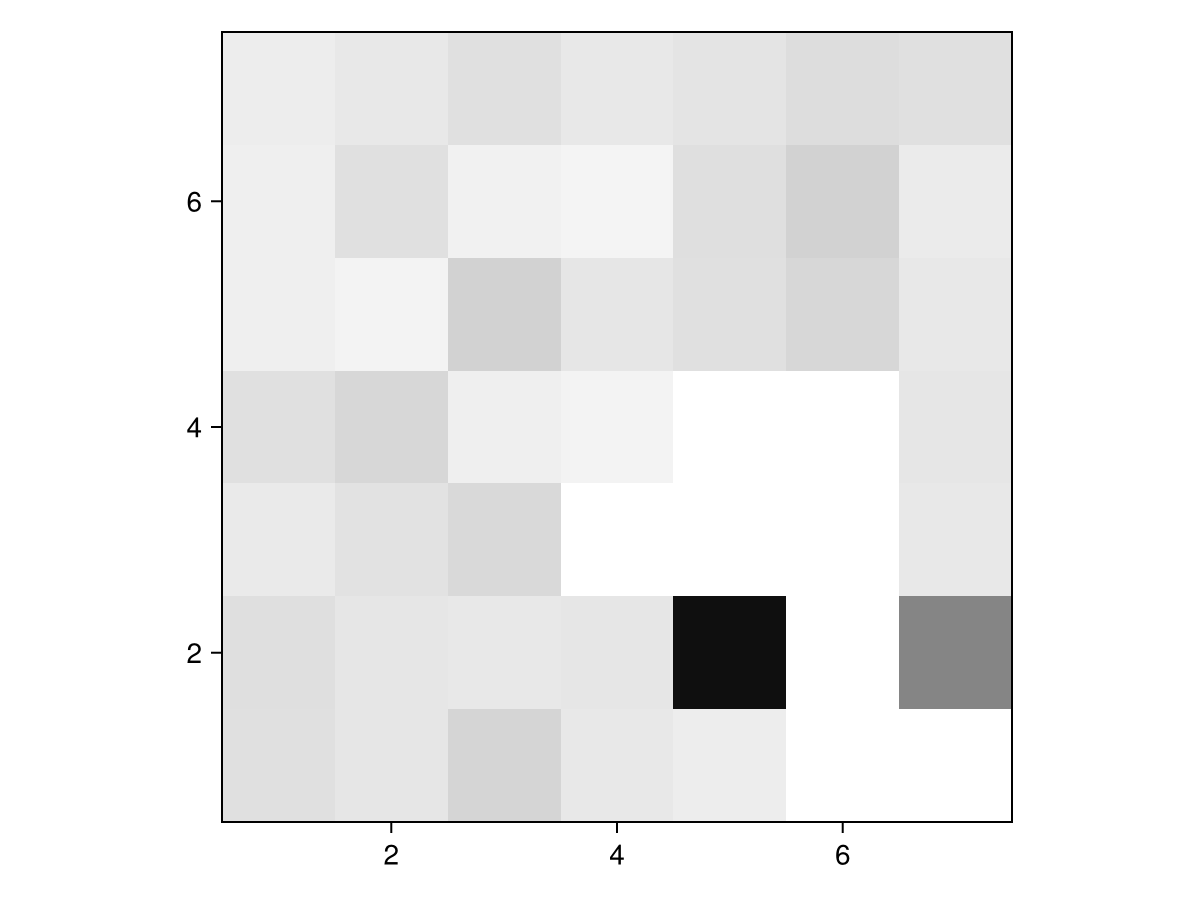

 . . # . . . .
 . # . . . . .
 . . . # # . .
 . . . . . X .
 G # # . . . .
 . . # . # . #
 . . . . . . .


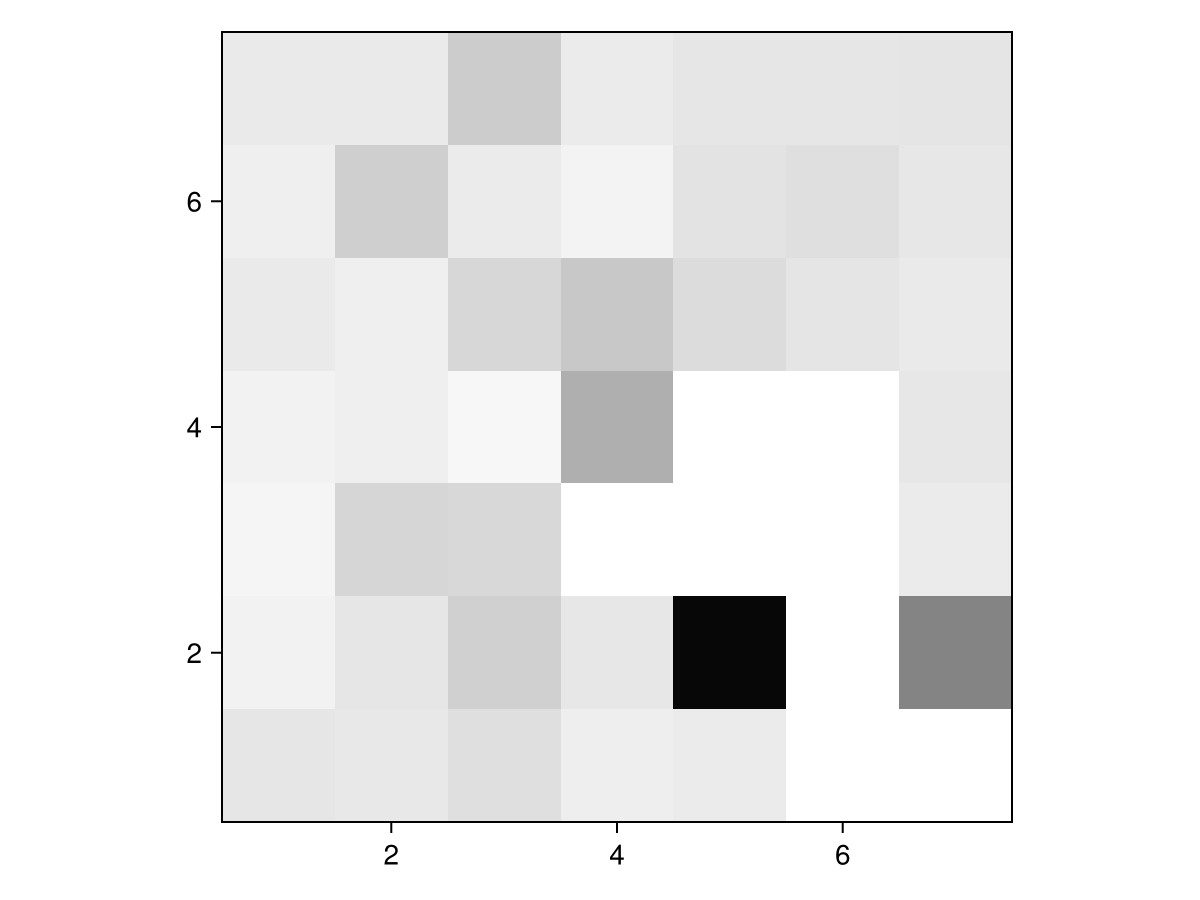

 # . # # . G .
 . . # . . . .
 # . . . . . .
 . . . # . X .
 . . . . . . .
 . # . . # . .
 # . . . . . .


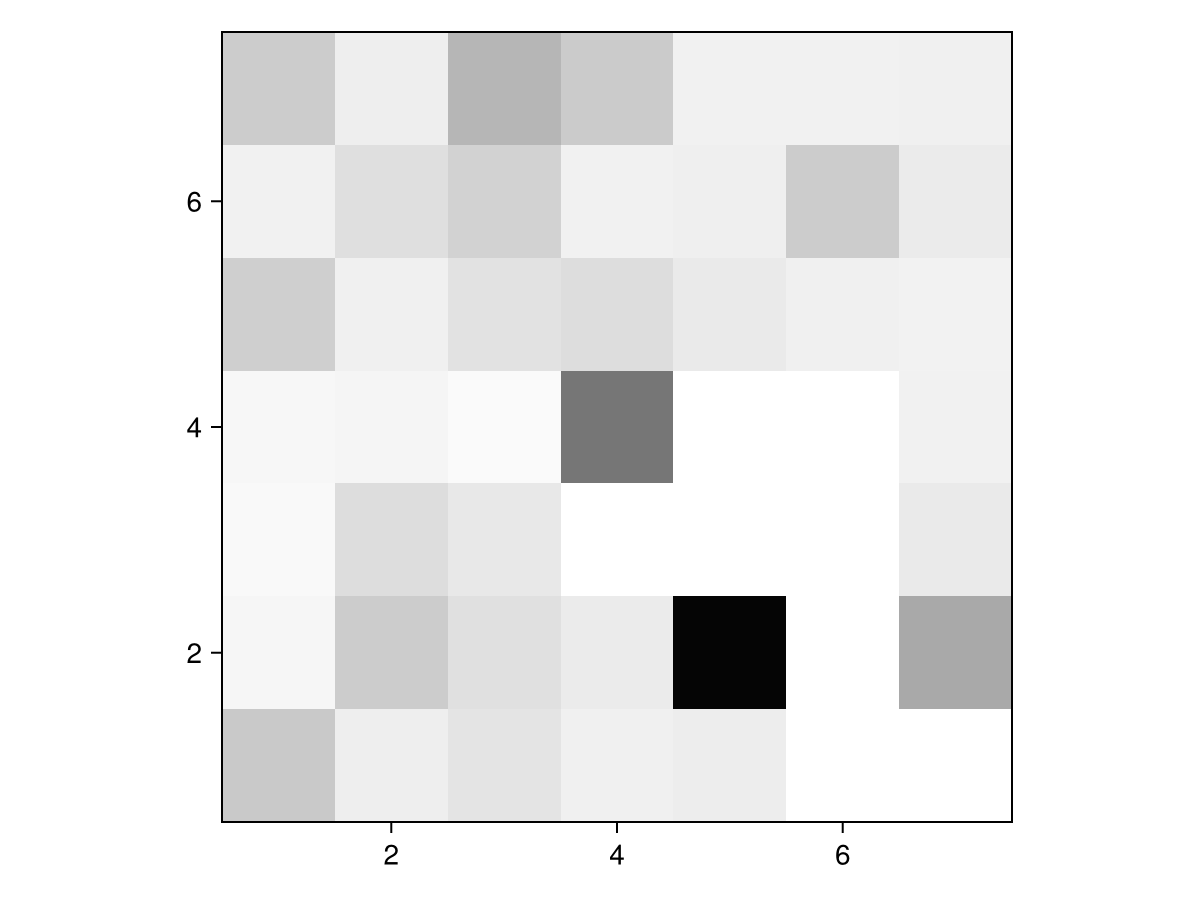

 . . . . . . .
 . . G . . # .
 . # . # . . .
 . . . # . X .
 . # . . . . #
 . . . . # . .
 . . . . . . .


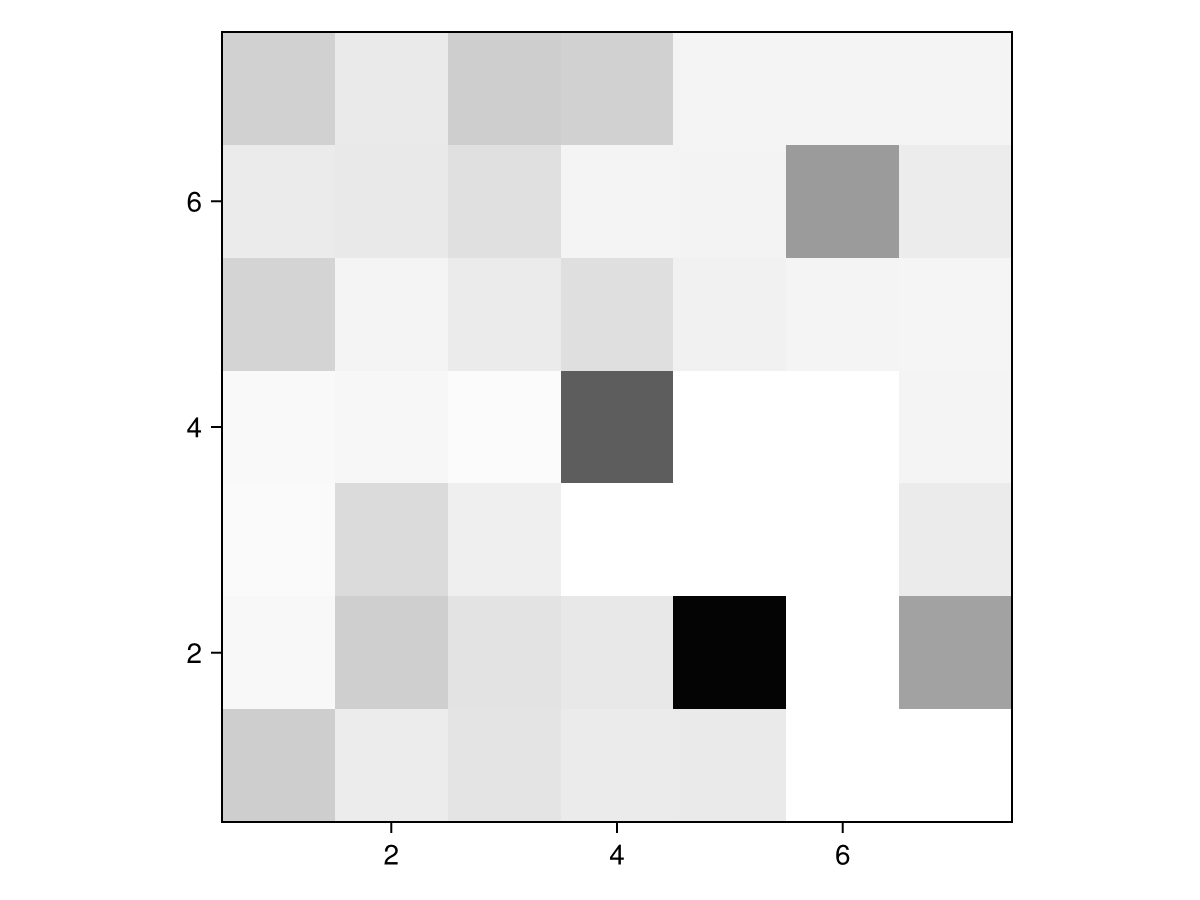

 . . . . . . .
 . G . . . # #
 . . . . . . .
 . . . # . X .
 . # . . . . .
 . . . . # . #
 # . . . . . .


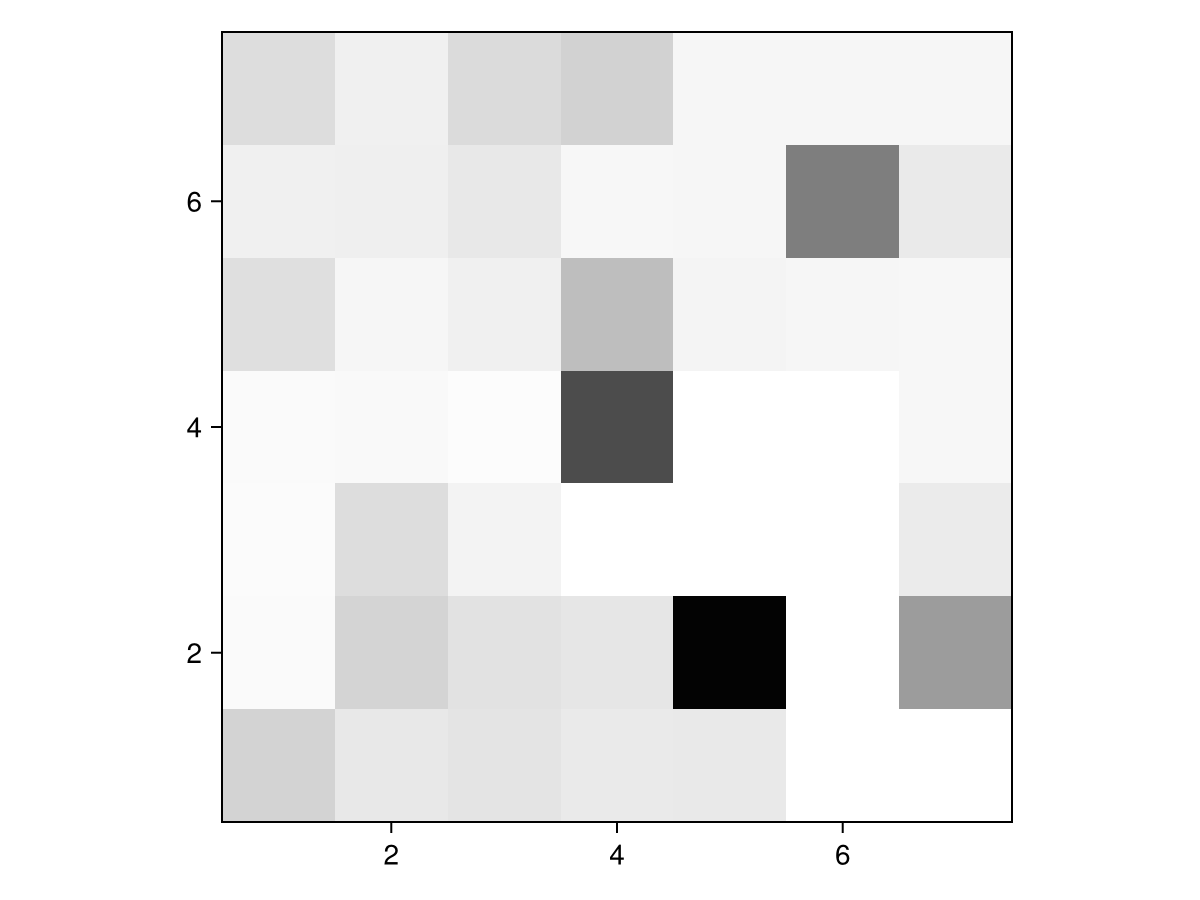

 . . . # . . .
 . G . . . # #
 . . . # . . .
 . . . # . X .
 . . . . . . .
 . . . # # . #
 . . . . . . .


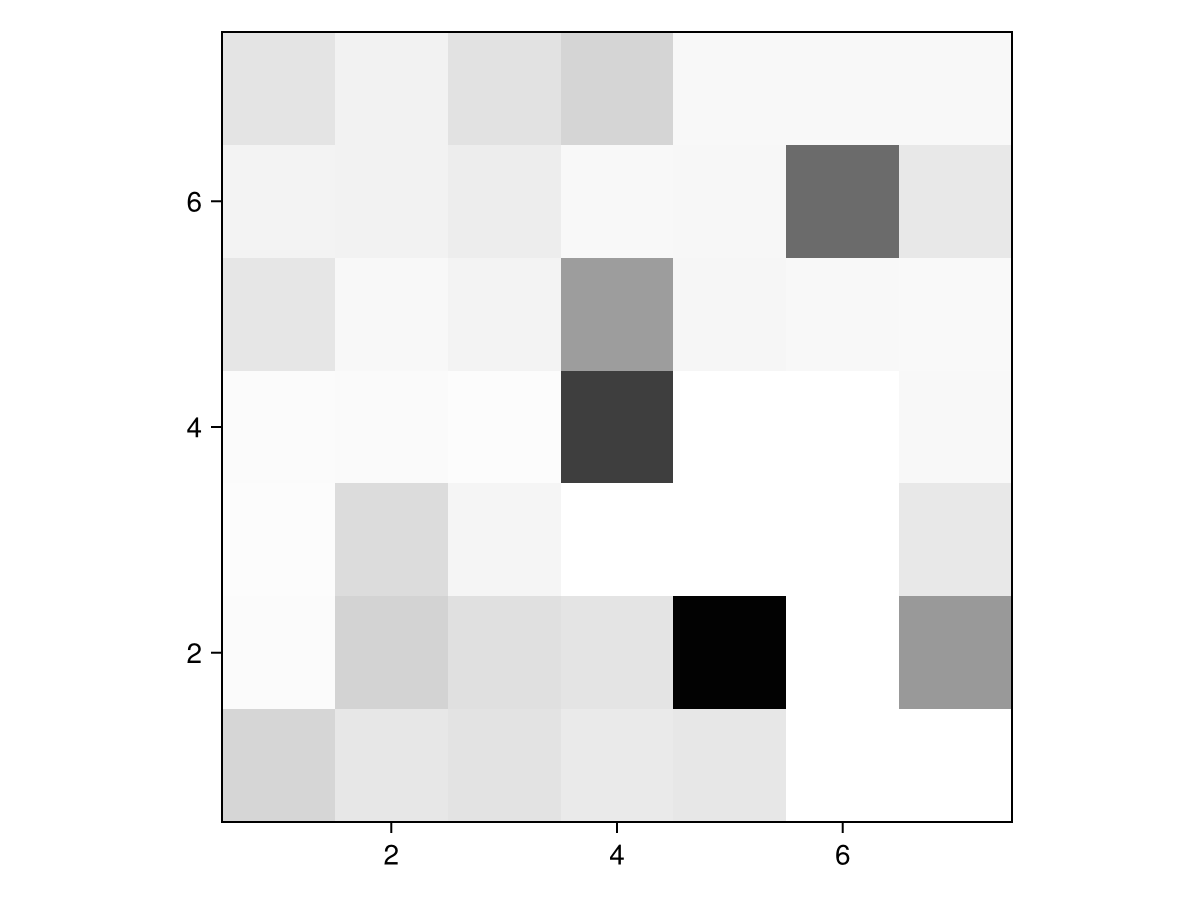

 . . . . . . .
 . G . . . # #
 . . . # . . .
 . . . # . X .
 . . . . . . .
 . . # . # . .
 . # . # # . .


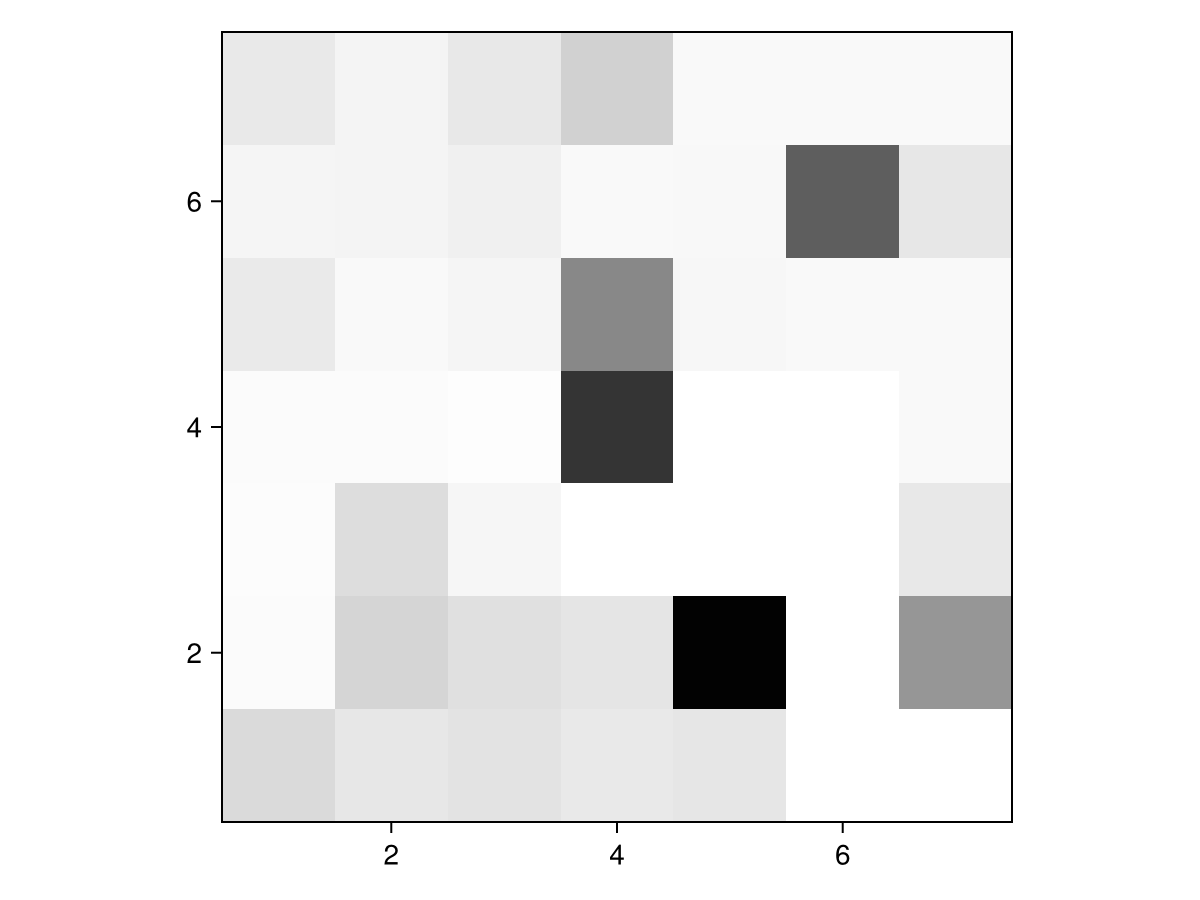

 . . . . . . .
 . G . . . # .
 . . . # . . .
 . . . # . X .
 . . . . . . .
 . . . . # . #
 . . . . . . .


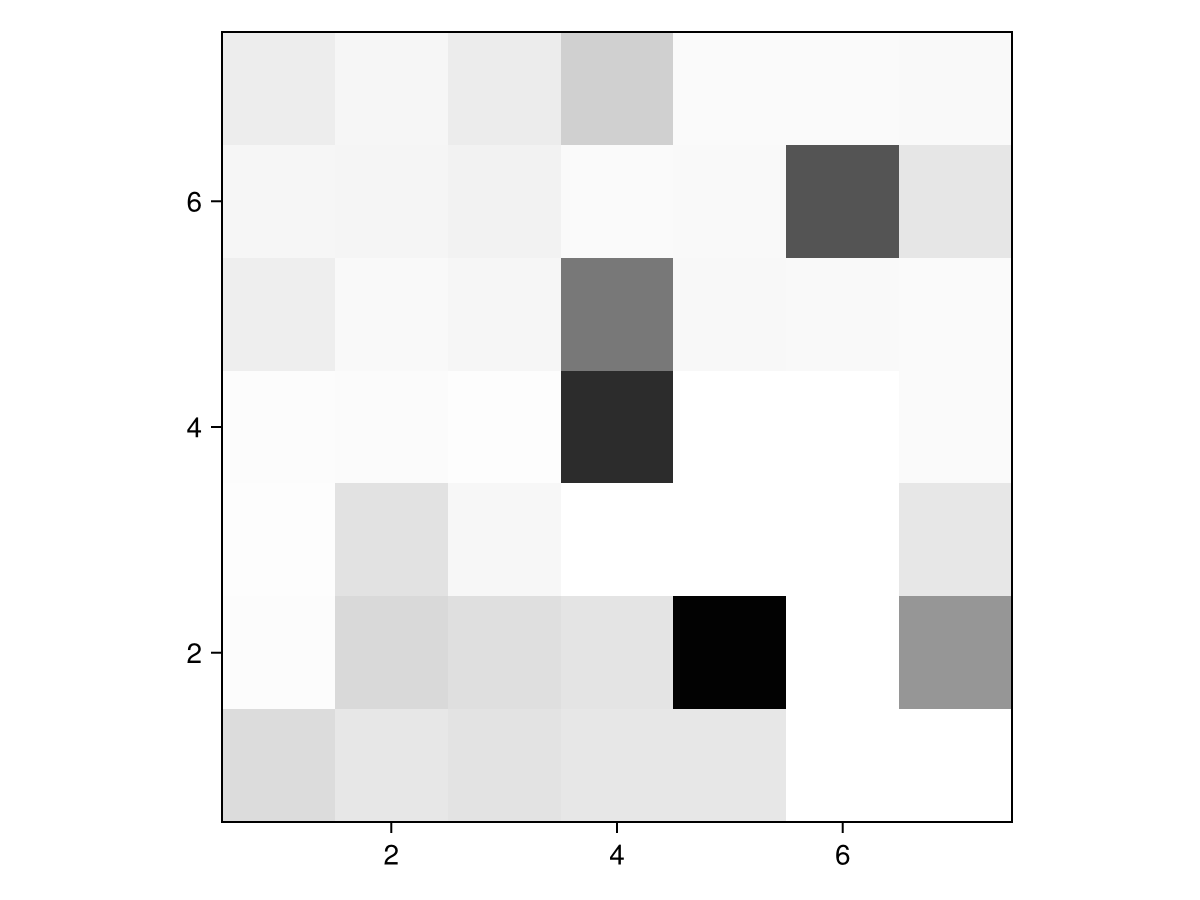

 . . . # . . .
 . G . . . # .
 . . . # . . .
 . . . # . X .
 . . . . . . .
 . . # . # . #
 . . . . . . .


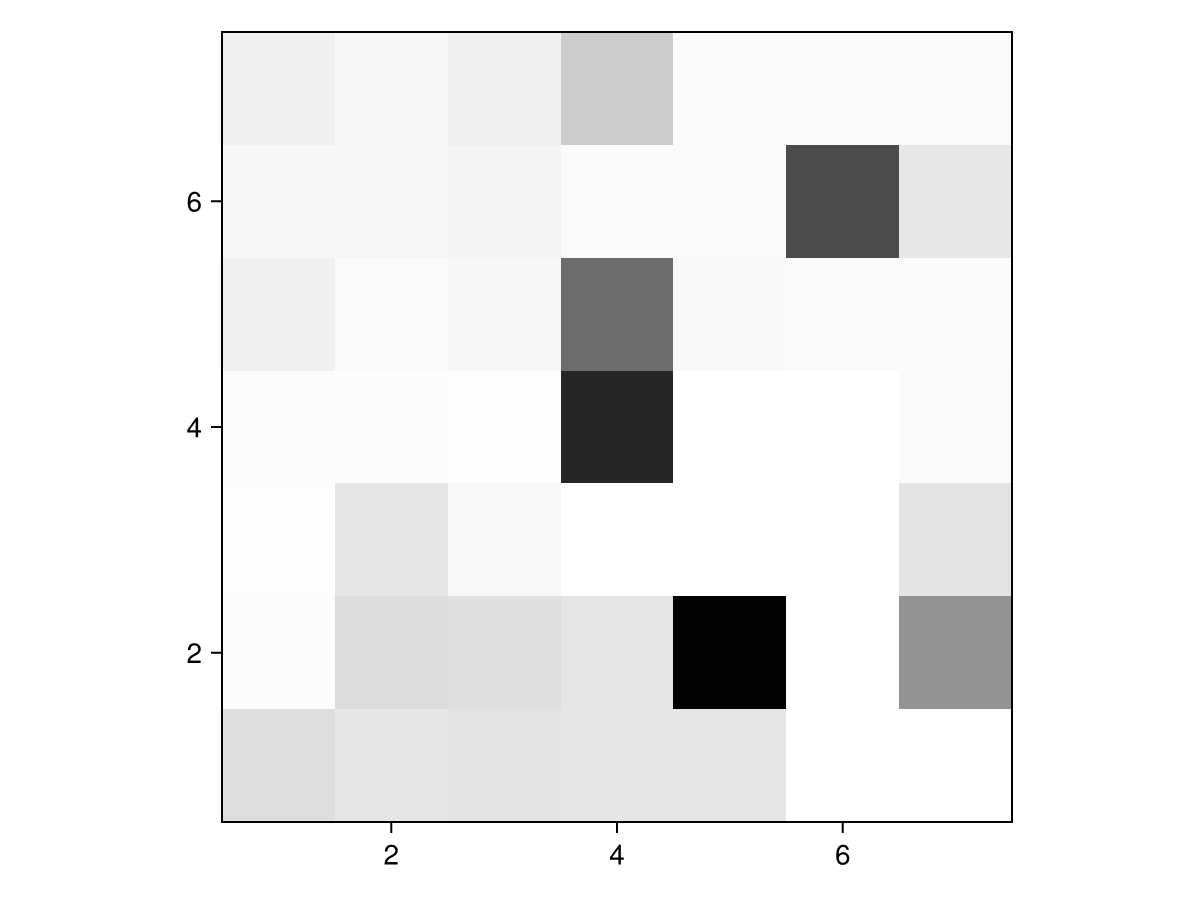

 . . . . . . .
 . G . . . # .
 . . . # . . .
 . . . # . X .
 . . . . . . .
 . . . . # . .
 . . . . . . .


In [649]:
Random.seed!(1)
environment, start = generate_nondet_environment(7);
print_maze(environment.maze, start)

policies, traces = iterative_thompson_propose(environment, start, 49, 10, 100);

In [650]:
print_maze(environment.maze, start)
println()
print_maze(traces[end][:maze], start)



 . . . . . . .
 . G . . . # .
 . . . # . . .
 . . . # . X .
 . . . . . . .
 . . . . # . #
 . # # . . . .

 . . . . . . .
 . G . . . # .
 . . . # . . .
 . . . # . X .
 . . . . . . .
 . . . . # . .
 . . . . . . .


 . . . . . . . . . .
 # . # # . # # . . .
 # . . . . . . # # #
 . . . . . . . . . #
 . . . . . # # . . .
 . # . . . # # . . .
 . . . . # . . . . .
 . . . . . . . . . X
 . G . . . . . . . .
 . . . . . . . . . .


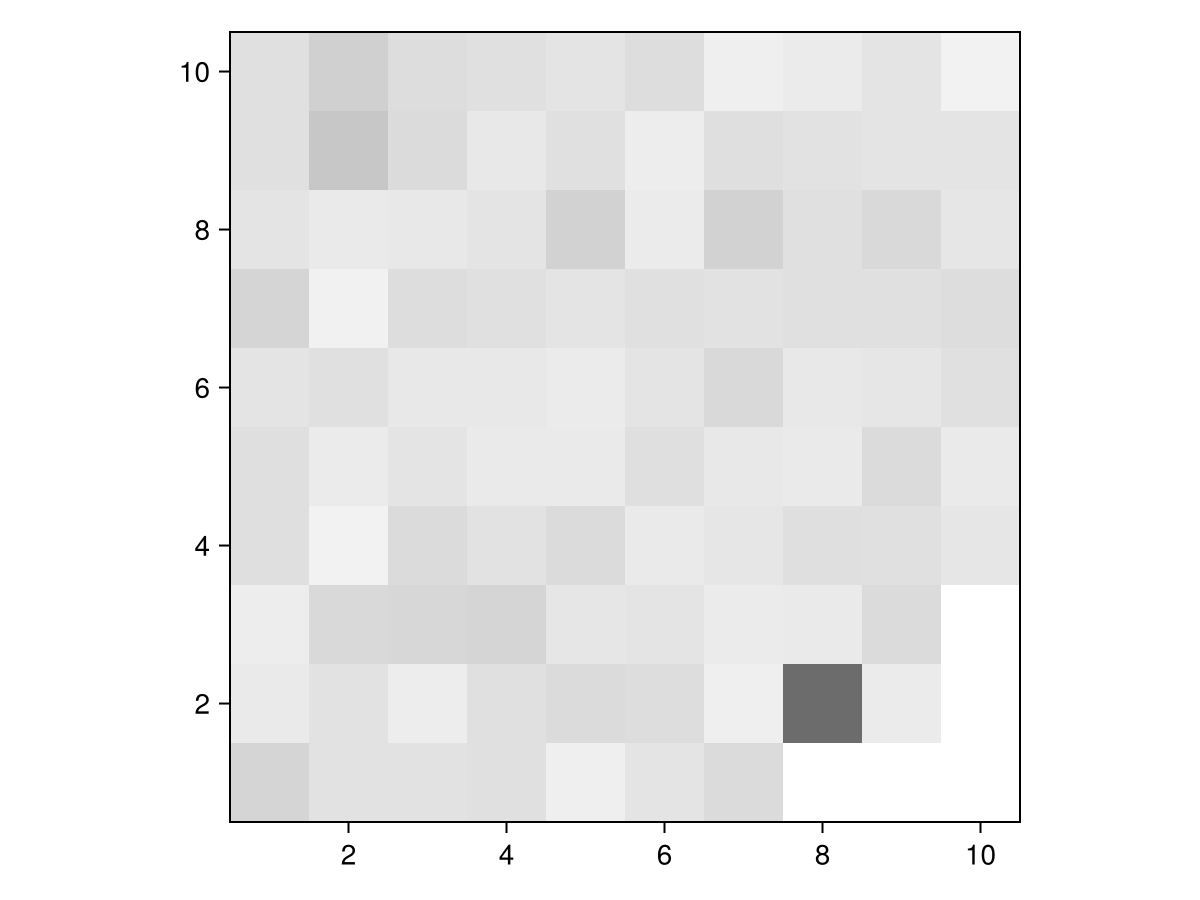

 . # # # . . . G . .
 . # # . . . # . . .
 . . . . . . # . # #
 . # # . # . . . . .
 . . . . . . . . . .
 . . . . . . # . . .
 . . # . . . . . . .
 . . . . . . # . . X
 . # . . . . . # . .
 . . . # . . . . . .


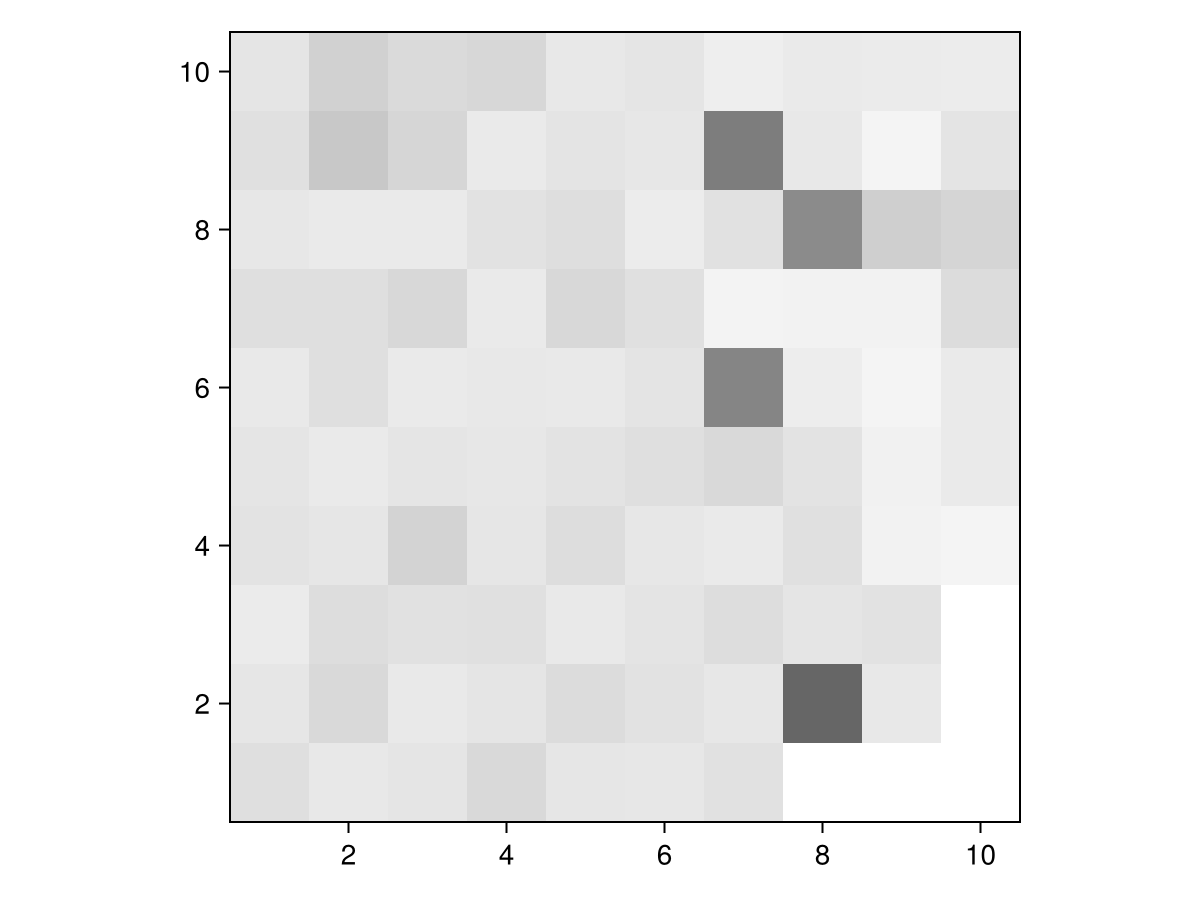

 . . . . . . . . . .
 . . . . # . # . G .
 . . . . . . . # # .
 # . . . . . . . . .
 . . . . . . # . . .
 . . . . . . # # . .
 . # . . . . # . . .
 # . . # . . . # . X
 . # . . # # . # . .
 . . . . . . . . . .


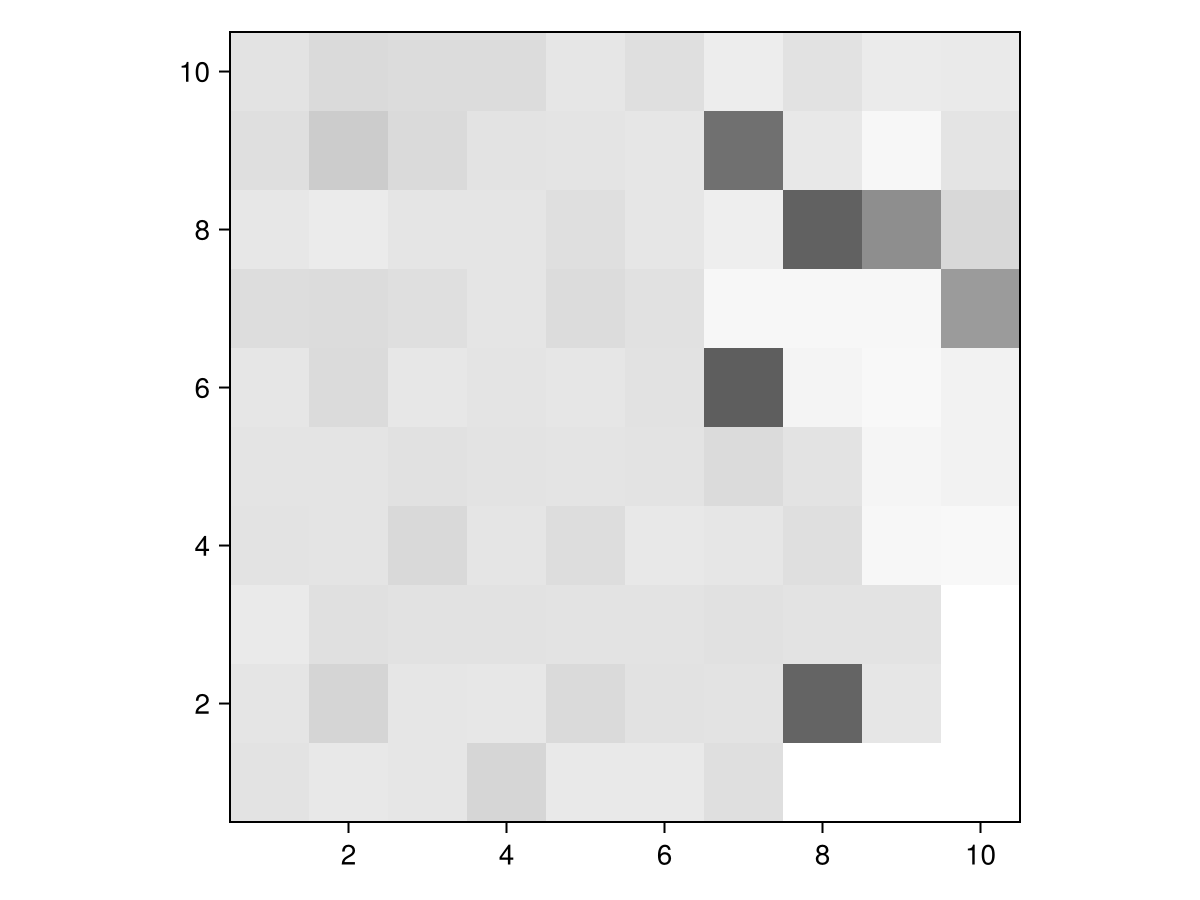

 . . . . . . . # . #
 . . . . . . # # G .
 . . . # # # . # # #
 . . . # # . . . . #
 . # . . . . # . . .
 . . . . # . . . . .
 . . # . # . . . . .
 . . # . . . . . . X
 # . . . . # # . . .
 . . . # . . . . . .


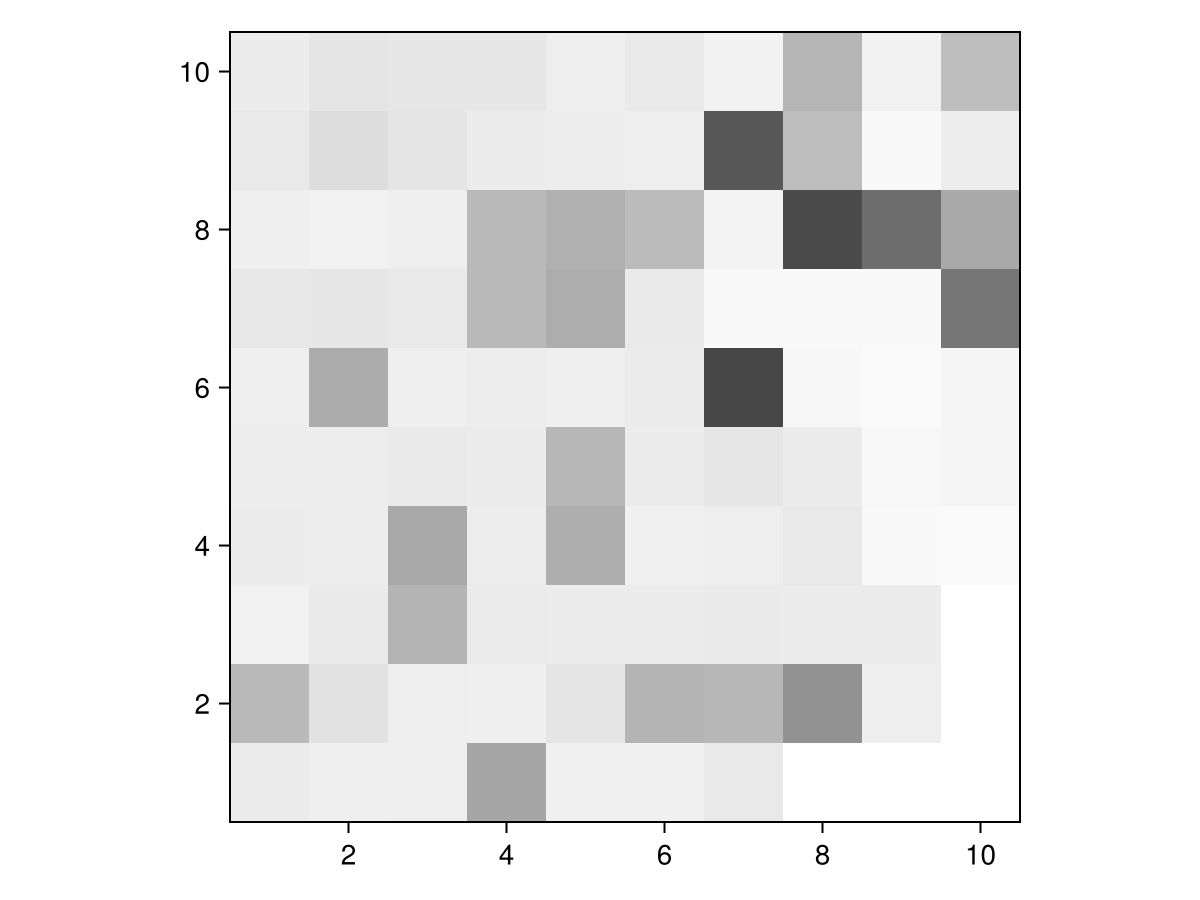

 . . . . . . . # . #
 . . . . . . # # G .
 . . . # # # . # # #
 . . . # # . . . . #
 . # . . . . # . . .
 . . . . # . . . . .
 . . # . # . . . . .
 . . # . . . . . . X
 # . . . . # # . . .
 . . . # . . . . . .


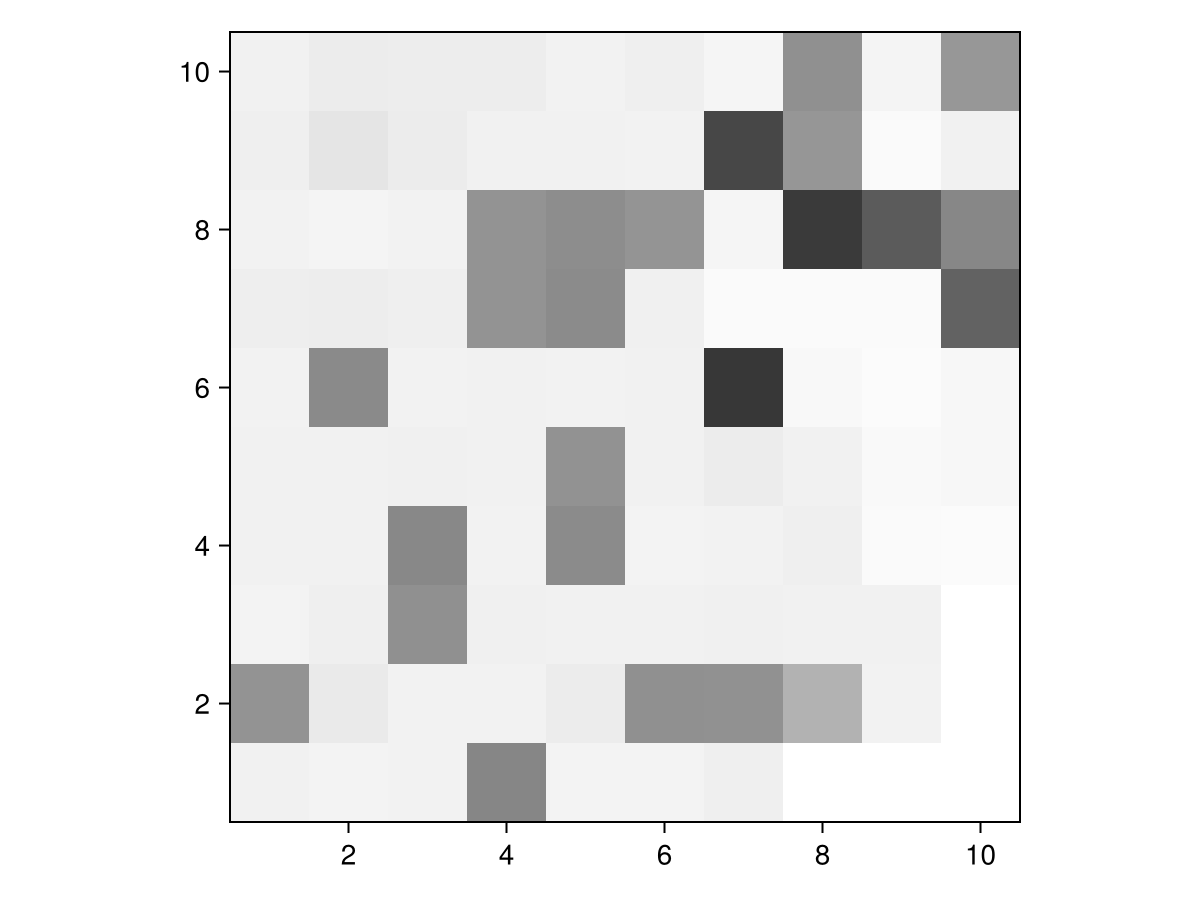

 . . . . . . . # . #
 . . . . . . # # G .
 . . . # # # . # # #
 . . . # # . . . . #
 . # . . . . # . . .
 . . . . # . . . . .
 . . # . # . . . . .
 . . # . . . . . . X
 # . . . . # # . . .
 . . . # . . . . . .


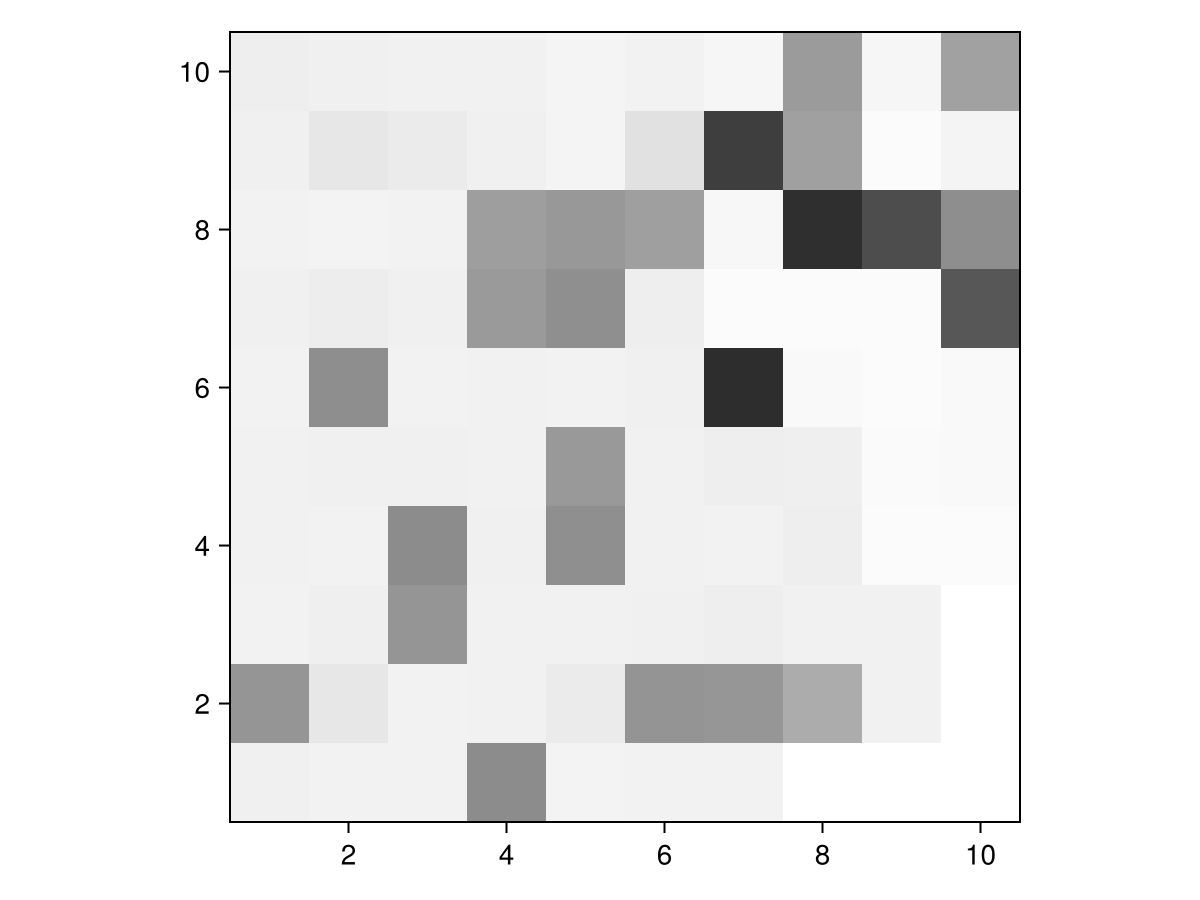

 . . . . . . . . . .
 . . . . . # # . . .
 . # # . . . . # # .
 # . . . # . . . . #
 . . # . . . # . . .
 . . . . . . . . . .
 . . . . . . . . . .
 . . . # # # # . . X
 . . . . . . . . # .
 . . . . . . G . . .


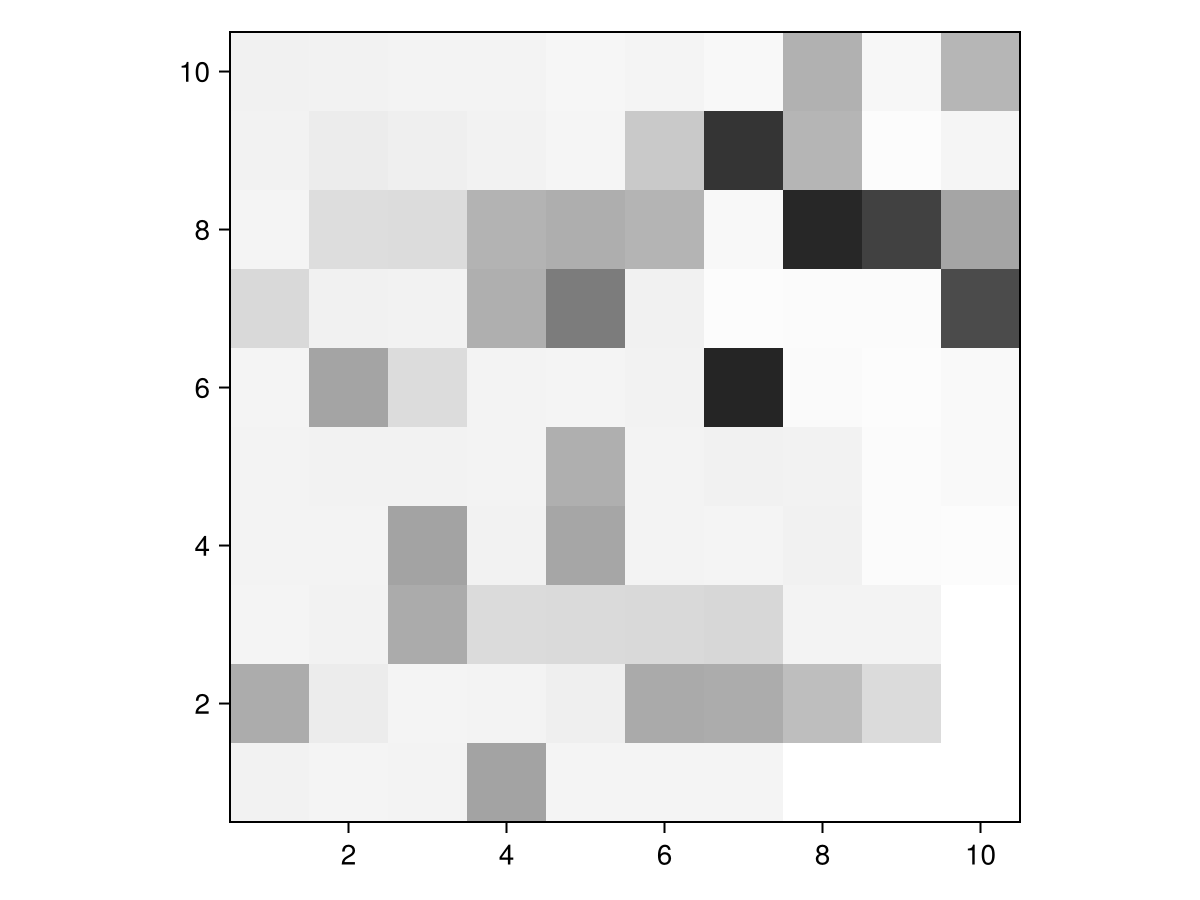

 . . . . . . . . . .
 . . . . . # # . . .
 . # # . . . . # # .
 # . . . # . . . . #
 . . # . . . # . . .
 . . . . . . . . . .
 . . . . . . . . . .
 . . . # # # # . . X
 . . . . . . . . # .
 . . . . . . G . . .


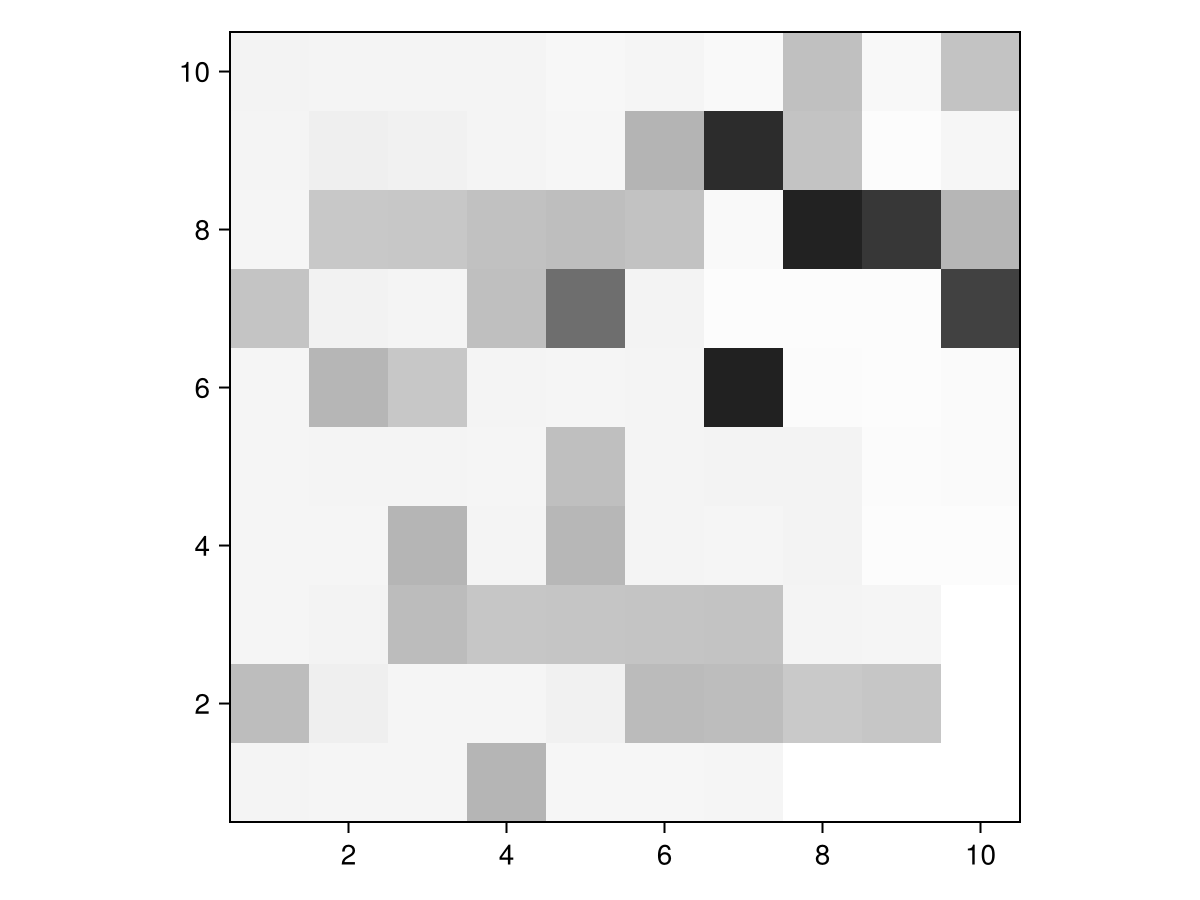

 . . . . . . . . . .
 . . . . . # # . . .
 . # # . . . . # # .
 # . . . # . . . . #
 . . # . . . # . . .
 . . . . . . . . . .
 . . . . . . . . . .
 . . . # # # # . . X
 . . . . . . . . # .
 . . . . . . G . . .


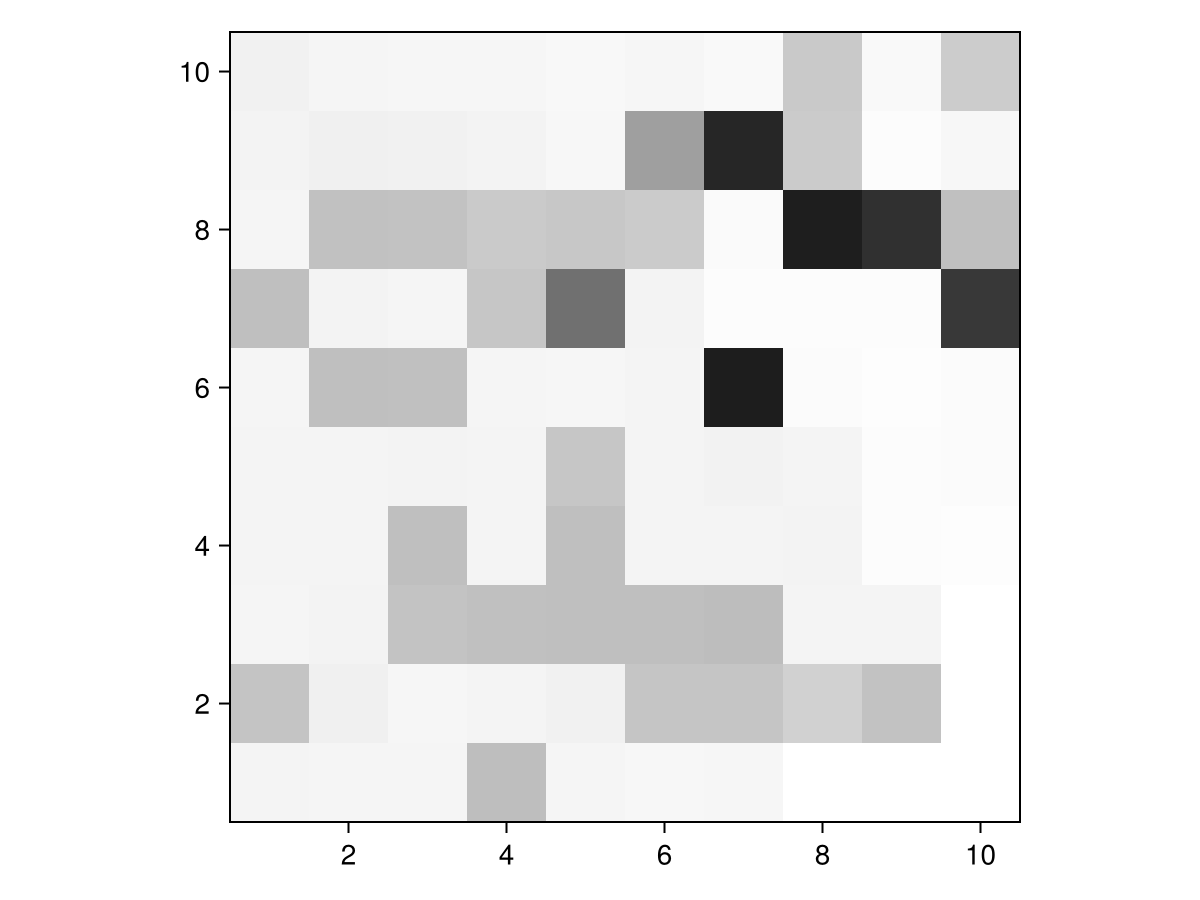

 # . . . . . . . . .
 . . . . . # # . . .
 . . . . . . . # # .
 . . G . . . . . . #
 . # . # . . # . . .
 # . . . . # . . . .
 . # . . . . . . . .
 . . # . # # . . . X
 . . . . . . . . . .
 . . . # . . . . . .


In [41]:
Random.seed!(2)
environment, start = generate_nondet_environment(10);
print_maze(environment.maze, start)

policies, traces = iterative_thompson_propose(environment, start, 100, 10, 100);